#                  Segmentation des clients du site E-Commerce Olist

Olist souhaite obtenir une segmentation de ses clients utilisable au quotidien par leur équipe marketing dans leurs campagnes de communication.
L'objectif est de comprendre les différents types d'utilisateurs grâce à leur comportement et à leurs données personnelles anonymisées.

Nous allons donc fournir ici une description actionable de la segmentation et de sa logique sous-jacente pour une utilisation optimale. Nous devrons également fournir une analyse de la stabilité des segments au cours du temps (dans le but d'établir un contrat de maintenance).

Nous utilisererons donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaire

# Sommaire

1. Clustering avec l'algorithme du K-Means
2. Réduction dimensionnelle - PCA
3. K-Means après réduction de dimenssions
4. Stabilité à l'initialisation du K-Means
5. Clustering avec l'algorithme du K-Prototypes
6. Stabilité temporelle de la segmentation
7. Clustering avec DBSCAN
8. Herarchiqual clustering selon Ward

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Standards Librairies import
%matplotlib inline
import os
from time import time
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

# Clustering Librairies import
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

# Personnal scripts
import sys
sys.path.append('/content/drive/MyDrive/P5_DS')
import P5_olist_functions as func_olist

mpl.rcParams["figure.figsize"] = (12, 8)
init_notebook_mode()
warnings.filterwarnings('ignore')

Output hidden; open in https://colab.research.google.com to view.

In [3]:
# root path for all dataset
drive= True
if drive == True:
  root_path= "/content/drive/MyDrive/olist/"
else:
  root_path = 'D:\\Downloads\\olist\\'

# olist_customers_dataset
data = pd.read_csv(root_path + "olist-customers-segmentation.csv")
data.head(5)

,customer_unique_id,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,books_cds_media,fashion_clothing_accessories,...,mean_nb_items,recency,order_mean_delay,freight_ratio,mean_price_order,customer_zip_code_prefix,customer_city,customer_state,Flag and name,harvesine_distance
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,1.0,8.0,5.0,6.0,5,0.0,0.0,...,1.0,236,111.0,0.08,129.90,7787,cajamar,São Paulo,São Paulo,209.713834
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,1.0,1.0,4.0,3.0,5,0.0,0.0,...,1.0,239,114.0,0.30,18.90,6053,osasco,São Paulo,São Paulo,209.713834
2,0000f46a3911fa3c0805444483337064,1,86.22,1.0,8.0,3.0,26.0,3,0.0,0.0,...,1.0,661,537.0,0.20,69.00,88115,sao jose,Santa Catarina,Santa Catarina,125.363853
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,1.0,4.0,4.0,20.0,10,0.0,0.0,...,1.0,445,321.0,0.40,25.99,66812,belem,Pará,Pará,1574.231129
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,1.0,6.0,5.0,13.0,11,0.0,0.0,...,1.0,412,288.0,0.09,180.00,18040,sorocaba,São Paulo,São Paulo,209.713834


In [ ]:
data.shape

(93358, 28)

# **Segmentation Basique RFM ( *Recency , Frequency , Monetary* )**

La RFM est une technique efficace de segmentation de la clientèle qui est très utile aux spécialistes du marketing pour faire des choix stratégiques dans l'entreprise. Elle permet aux responsables marketing de distinguer et de segmenter rapidement les clients en groupes similaires et de les cibler. Cela permet d'améliorer l'engagement et la fidélisation des clients.

In [4]:
data_RFM = data[["recency","nb_orders","total_spend"]]

In [5]:
data_RFM.rename({"recency" : "Recency",
                 "nb_orders" : "Frequency",
                 "total_spend" : "Monetary"},axis= 1,inplace=True)

In [6]:
data_RFM

,Recency,Frequency,Monetary
0,236,1,141.90
1,239,1,27.19
2,661,1,86.22
3,445,1,43.62
4,412,1,196.89
...,...,...,...
93353,571,1,2067.42
93354,386,1,84.58
93355,692,1,112.46
93356,243,1,133.69


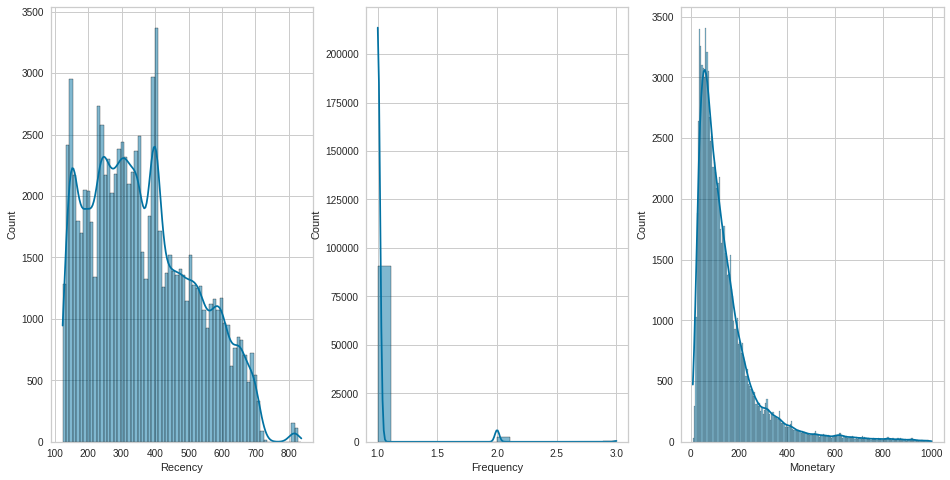

In [7]:
import seaborn as sns
scaler = MinMaxScaler()
data_RFM_normalized = scaler.fit_transform(data_RFM[["Recency","Frequency","Monetary"]])
preprocessor = ColumnTransformer([
    ('scaler', scaler, data_RFM.columns)])
data_RFM_normalized = pd.DataFrame(data_RFM_normalized, columns= data_RFM.columns)

fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# Recency distribution plot
sns.histplot(data_RFM['Recency'], kde=True, ax=ax[0])

# Frequency distribution plot
sns.histplot(data_RFM['Frequency'][data_RFM['Frequency'] <= 3], kde=True, ax=ax[1])

# Monetary distribution plot
sns.histplot(data_RFM['Monetary'][data_RFM['Monetary'] < 1000] , kde=True, ax=ax[2])

In [8]:
data_RFM.describe()

,Recency,Frequency,Monetary
count,93358.000000,93358.000000,93358.000000
mean,364.394428,1.033420,165.168210
std,153.100039,0.209097,226.292101
min,124.000000,1.000000,9.590000
25%,240.000000,1.000000,63.010000
50%,346.000000,1.000000,107.780000
75%,474.000000,1.000000,182.510000
max,837.000000,15.000000,13664.080000


In [9]:
res_R, bins_R = pd.qcut(data_RFM["Recency"],4,retbins = True)
res_F, bins_F = pd.qcut(data_RFM["Frequency"],4,retbins = True,duplicates="drop")
res_M, bins_M = pd.qcut(data_RFM["Monetary"],4,retbins = True)


In [10]:
bins_F

array([ 1., 15.])

Pour établir un score du RFM, nous devons échantillonner nos variables afin d'avoir un score entre 1 et 5

In [11]:
precentiles={
    'amount':bins_R,
    'frequency':[],
    'recency':bins_R
    }


In [12]:
data_RFM.Frequency.unique()

array([ 1,  2,  3,  4,  6,  7,  5,  9, 15])

On remarque ici, que plus de 75% de la fréquence d'achat est égale à 1.

En regardant les valeurs uniques, nous allons finalement cutter les valeurs comme suit : {1 , 3 , 6 , 9}

In [13]:
precentiles['frequency'] = [1 , 3 , 6 , 9 ]

In [14]:
# create a list of our conditions, more frequency is rated more.
conditions = [
    (data_RFM['Frequency'] <= precentiles['frequency'][0]),
    (data_RFM['Frequency'] > precentiles['frequency'][0]) & (data_RFM['Frequency'] <= precentiles['frequency'][1]) ,
    (data_RFM['Frequency'] > precentiles['frequency'][1]) & (data_RFM['Frequency'] <= precentiles['frequency'][2])  ,
    (data_RFM['Frequency'] > precentiles['frequency'][2]) & (data_RFM['Frequency'] <= precentiles['frequency'][3])  ,
    (data_RFM['Frequency'] > precentiles['frequency'][3])
    ]# create a list of the values we want to assign for each condition
values = [1, 2, 3, 4,5]# create a new column and use np.select to assign values to it using our lists as arguments
data_RFM['Fscore'] = np.select(conditions, values)# create a list of our conditions, recency is rated in the opposite order
conditions = [
    (data_RFM['Recency'] <= precentiles['recency'][0]),
    (data_RFM['Recency'] > precentiles['recency'][0]) & (data_RFM['Recency'] <= precentiles['recency'][1]) ,
    (data_RFM['Recency'] > precentiles['recency'][1]) & (data_RFM['Recency'] <= precentiles['recency'][2])  ,
    (data_RFM['Recency'] > precentiles['recency'][2]) & (data_RFM['Recency'] <= precentiles['recency'][3])  ,
    (data_RFM['Recency'] > precentiles['recency'][3])
    ]# create a list of the values we want to assign for each condition
values = [5,4,3,2,1]# create a new column and use np.select to assign values to it using our lists as arguments
data_RFM['Rscore'] = np.select(conditions, values)# create a list of our conditions, more Amount is rated more
conditions = [
    (data_RFM['Monetary'] <= precentiles['amount'][0]),
    (data_RFM['Monetary'] > precentiles['amount'][0]) & (data_RFM['Monetary'] <= precentiles['amount'][1]) ,
    (data_RFM['Monetary'] > precentiles['amount'][1]) & (data_RFM['Monetary'] <= precentiles['amount'][2])  ,
    (data_RFM['Monetary'] > precentiles['amount'][2]) & (data_RFM['Monetary'] <= precentiles['amount'][3])  ,
    (data_RFM['Monetary'] > precentiles['amount'][3])
    ]# create a list of the values we want to assign for each condition
values = [1, 2, 3, 4,5]# create a new column and use np.select to assign values to it using our lists as arguments
data_RFM['Mscore'] = np.select(conditions, values)
data_RFM.head()

,Recency,Frequency,Monetary,Fscore,Rscore,Mscore
0,236,1,141.90,1,4,2
1,239,1,27.19,1,4,1
2,661,1,86.22,1,1,1
3,445,1,43.62,1,2,1
4,412,1,196.89,1,2,2


In [15]:
data_RFM["rfm_score"] = data_RFM['Rscore'] + data_RFM["Fscore"] + data_RFM["Mscore"]
data_RFM["rfm_Kmeans"] = data_RFM['Rscore'].astype(str) + ((data_RFM["Fscore"] + (data_RFM["Mscore"])/2).astype(int)).astype(str)
data_RFM=data_RFM.drop(labels=['Fscore','Rscore','Mscore'],axis=1)
data_RFM['rfm_Kmeans']=data_RFM['rfm_Kmeans'].astype(int)
data_RFM.head(5)

,Recency,Frequency,Monetary,rfm_score,rfm_Kmeans
0,236,1,141.90,7,42
1,239,1,27.19,6,41
2,661,1,86.22,3,11
3,445,1,43.62,4,21
4,412,1,196.89,5,22


Ici nous segmentons les clients par rapport au Score RFM

In [16]:
data_RFM['rfm_score'].min()

3

In [17]:
def rfm_level(df):
  if (df["rfm_score"] >= 9):
    return "Best Customers"
  elif (df["rfm_score"] < 9) and (df["rfm_score"] >= 7) : return "Loyal"
  elif (df["rfm_score"] < 7) and (df["rfm_score"] >= 6) : return "Needs Attention"
  elif (df["rfm_score"] < 6) and (df["rfm_score"] >= 4) : return "Potential"
  else : return "Lost Customers"
data_RFM["RFM_Level"] = data_RFM.apply(rfm_level,axis=1)
display(data_RFM.head())

  

,Recency,Frequency,Monetary,rfm_score,rfm_Kmeans,RFM_Level
0,236,1,141.90,7,42,Loyal
1,239,1,27.19,6,41,Needs Attention
2,661,1,86.22,3,11,Lost Customers
3,445,1,43.62,4,21,Potential
4,412,1,196.89,5,22,Potential


In [18]:
RFM_stats = data_RFM.groupby("RFM_Level").agg({'Recency' : 'mean',
                                               'Frequency': 'mean',
                                               'Monetary' : ['mean','count','sum']}).round(1)
RFM_stats.columns= RFM_stats.columns.droplevel()
RFM_stats.columns = ["Recency_Mean","Frequency_Mean","Monetary_Mean","Monetary_Count","Monetary_Sum"]
display(RFM_stats)

,Recency_Mean,Frequency_Mean,Monetary_Mean,Monetary_Count,Monetary_Sum
RFM_Level,,,,,
Best Customers,233.3,1.2,746.1,3363,2509097.2
Lost Customers,577.6,1.0,69.4,13169,914385.1
Loyal,273.0,1.1,338.9,14054,4762900.8
Needs Attention,250.1,1.0,128.1,22578,2893297.1
Potential,401.7,1.0,108.0,40194,4340093.5


In [19]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Visualisation de la segmentation RFM des clients

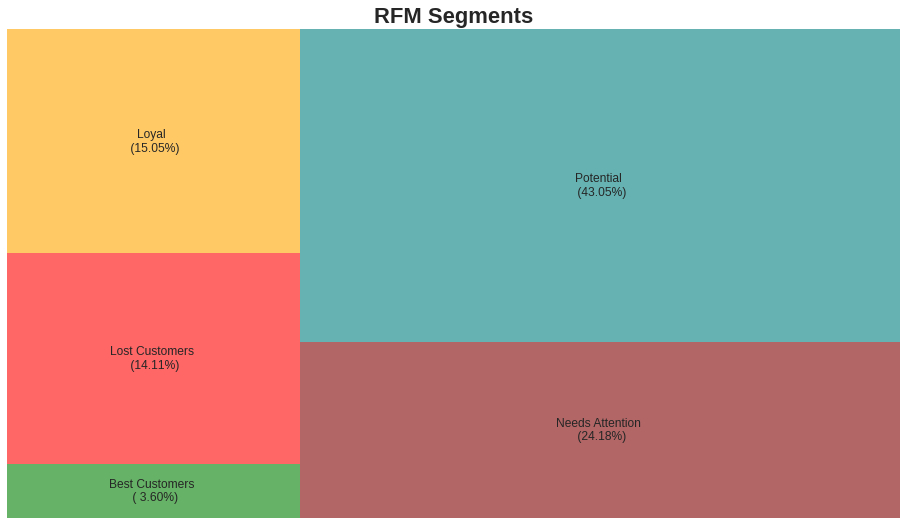

In [20]:
import squarify
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16,9)
perc = [f'{i/RFM_stats["Monetary_Count"].sum()*100:5.2f}%' for i in RFM_stats["Monetary_Count"]]
lbl = [f'{el[0]} \n ({el[1]})' for el in zip( RFM_stats.index, perc)]
squarify.plot(sizes= RFM_stats["Monetary_Count"],
              label = lbl,
              
              color = ["Green","Red","Orange","Maroon",'Teal'],
              alpha=.6)
plt.title("RFM Segments", fontsize = 22, fontweight="bold")
plt.axis("off")
plt.show()

# Clustering avec l'algorithme du K-Means

## Explication de l'algorithme

 K-Means C’est l’un des algorithmes de clustering les plus répandus. Il permet d’analyser un jeu de données caractérisé par un ensemble de descripteurs, afin de regrouper les données “similaires” en groupes *(ou clusters).

Après avoir initialisé des centroïdes en prenant des données au hasard dans le jeu de données, K-means alterne plusieurs fois ces deux étapes pour optimiser les centroïdes et leurs groupes : 

1. Regrouper chaque objet autour du centroïde le plus proche. 
2. Replacer chaque centroïde selon la moyenne des descripteurs de son groupe.

L’algorithme a convergé après un certain nombre d'itérations et trouve un découpage stable du jeu de données. Cependant, le nombre de Clusters est à définir par l'utilisateur. 

## Méthode du coude
 
KElbowVisualizer de Yellowbrick implémente la méthode du «coude» pour sélectionner le nombre optimal de clusters en ajustant le modèle K-Means avec une plage de valeurs pour K. Si le graphique en courbes ressemble à un bras, alors le «coude» (le point d'inflexion sur la courbe) est une bonne indication du nombre de K optimal.

In [21]:
scaler = MinMaxScaler()
data_RFM_normalized = scaler.fit_transform(data_RFM[["Recency","Frequency","Monetary"]])
preprocessor = ColumnTransformer([
    ('scaler', scaler, data_RFM.columns)])

In [22]:
data_RFM_normalized = pd.DataFrame(data_RFM_normalized,columns=["Recency","Frequency","Monetary"])
data_RFM_normalized = pd.concat([data_RFM_normalized ,data_RFM['rfm_Kmeans']],axis=1)

# **K-MEANS + RFM**

En général, si la fréquence augmente, le montant dépensé augmente aussi. Donc, je vais additionner le Fscore et la moitié du Mscore (pour ne pas dépasser 9) et concaténer ce score avec le score de Récence. Cela signifie que si un client a un score RFM de 5 2 2, il aura un score de 53. Ce score peut changer en fonction des besoins de l'entreprise.

In [23]:
"""data_RFM["rfm_Kmeans"] = data_RFM['Rscore'].astype(str) + ((data_RFM["Fscore"] + (data_RFM["Mscore"])/2).astype(int)).astype(str)
data_RFM['rfm_Kmeans']=data_RFM['rfm_Kmeans'].astype(int)"""

'data_RFM["rfm_Kmeans"] = data_RFM[\'Rscore\'].astype(str) + ((data_RFM["Fscore"] + (data_RFM["Mscore"])/2).astype(int)).astype(str)\ndata_RFM[\'rfm_Kmeans\']=data_RFM[\'rfm_Kmeans\'].astype(int)'

In [24]:
def clustering_eval(preprocessor, model, data, metric, elbow=True, mds=False, KBest=None,RFM=False):
    
    if((elbow==True) & (mds==True)):
        ncols=3
    elif((elbow==False) | (mds==False)):
        ncols=2
    else:
        ncols=1
        
    fig, axes = plt.subplots(nrows=1, ncols=ncols, sharex=False, sharey=False, figsize=(24,8))
    
    ax=0
    if(elbow==True):
        # Elbow visualizer
        if RFM == False :
          kmeans_visualizer = Pipeline([
              ("preprocessor", preprocessor),
              ("kelbowvisualizer", KElbowVisualizer(model,K=(2,12), metric=metric, ax=axes[ax]))])
          kmeans_visualizer.fit(data)
          KBest = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_
          kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
          ax+=1
        else:
          data_RFM_normalized = scaler.fit_transform(data[["Recency","Frequency","Monetary"]])
          data_RFM_normalized = pd.DataFrame(data_RFM_normalized,columns=["Recency","Frequency","Monetary"])
          data_RFM_normalized = pd.concat([data_RFM_normalized ,data['rfm_Kmeans']],axis=1)
          kmeans_visualizer = Pipeline([
              
              ("kelbowvisualizer", KElbowVisualizer(model,K=(2,12), metric=metric, ax=axes[ax]))])
          kmeans_visualizer.fit(data_RFM_normalized)
          KBest = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_
          kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
          ax+=1          
    # Set best K
    K = KBest
    model.set_params(n_clusters=K)

    # Silhouette Visualizer
    if RFM == False:
      silhouette_visualizer = Pipeline([
          ("preprocessor", preprocessor),
          ("silhouettevisualizer", SilhouetteVisualizer(model, ax=axes[ax]))])
      silhouette_visualizer.fit(data)
      silhouette_visualizer.named_steps['silhouettevisualizer'].finalize()
      ax+=1
    else:
      silhouette_visualizer = Pipeline([("silhouettevisualizer", SilhouetteVisualizer(model, ax=axes[ax]))])
      silhouette_visualizer.fit(data_RFM_normalized)
      silhouette_visualizer.named_steps['silhouettevisualizer'].finalize()
      ax+=1
    
    # Intercluster distance Map with best k
    if(mds==True):
      if RFM == False:
        distance_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("distancevisualizer", InterclusterDistance(model, ax=axes[ax]))])
        distance_visualizer.fit(data)
        distance_visualizer.named_steps['distancevisualizer'].finalize()
      else:
        distance_visualizer = Pipeline([ ("distancevisualizer", InterclusterDistance(model, ax=axes[ax]))])
        distance_visualizer.fit(data_RFM_normalized)
        distance_visualizer.named_steps['distancevisualizer'].finalize()
    
    return K
    plt.show()

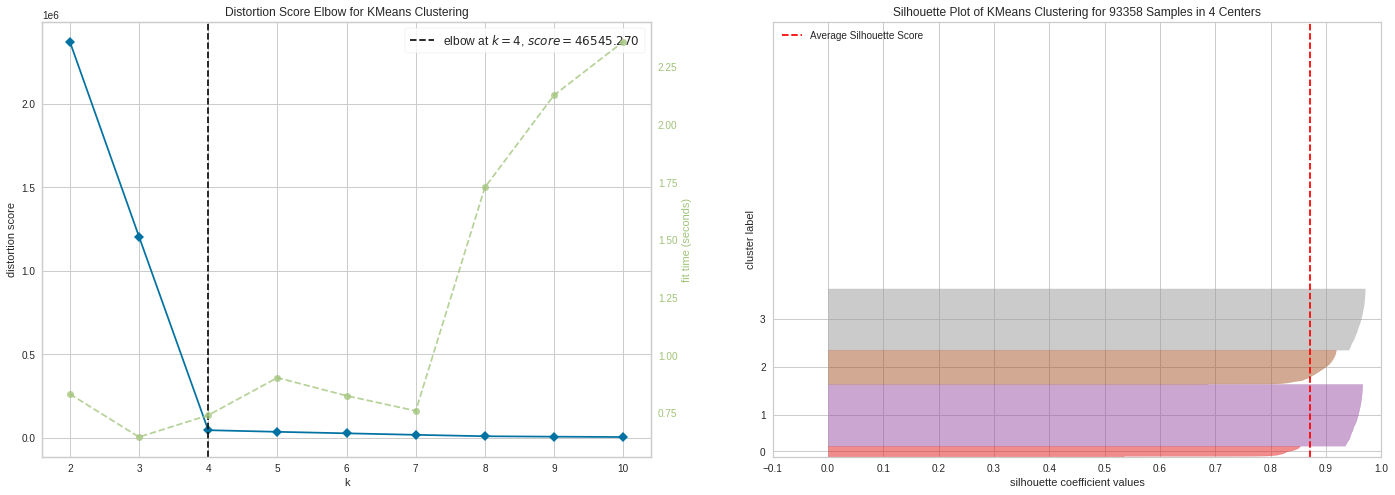

In [25]:
X = data_RFM.copy()
K = clustering_eval(preprocessor=MinMaxScaler(), 
                model=KMeans(), 
                data=X, 
                metric="distortion",
                elbow=True,
                mds=False,
                KBest=None,
                RFM=True)

Grâce à la méthode du coude basée sur le score de distortion (somme moyenne des carrés des distances aux centres), une segmentation en  K=4 clusters serait la meilleure option

Le score de chaque échantillon est calculé en faisant la moyenne du coefficient de silhouette (différence entre la distance moyenne intra-cluster et la distance moyenne du cluster le plus proche pour chaque échantillon), normalisée par la valeur maximale. Cela nous donne un score entre -1 et 1, qui nous permet de déterminer si la séparation est efficace ou si les points sont assignés au mauvais cluster.

Ici, les clusters semblent relativement bien répartis et les séparations sont claires avec cependant quelques erreurs sur l'un des clusters.

## **Distance Intercluster**

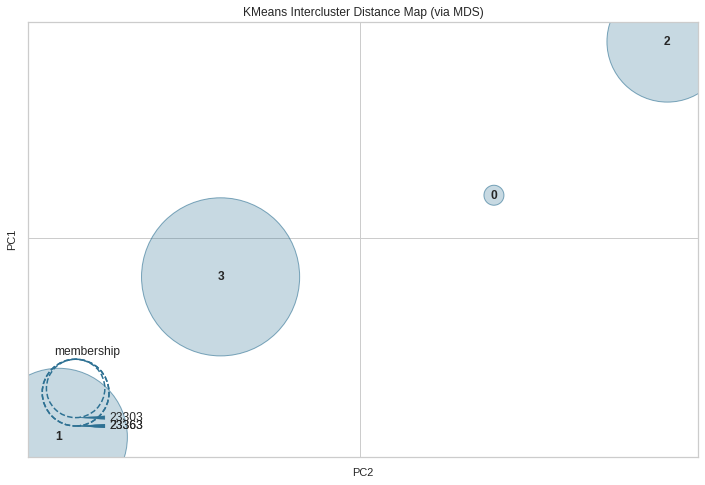

In [26]:
# Intercluster distance Map with best k
distance_visualizer = Pipeline([("distancevisualizer", InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(data_RFM_normalized)
distance_visualizer.named_steps['distancevisualizer'].show()

Sur cette projection en 2D, on remarque que les différents clusters sont bien séparés sur les 2 premières composantes principales. Le clustering semble donc performant et il faut a présent identifier les composantes métier de chaque cluster.

Analyse des différents clusters

A présent, nous allons entrainer notre KMeans avec le K optimal sélectionné et affecter son cluster à chaque client. Ainsi, nous pourrons analyser les différences entre chaque cluster :


In [27]:
# KMeans Pipeline with best K
kmeans_model = Pipeline([
                         ("kmeans", KMeans(K))])
kmeans_model.fit(data_RFM_normalized)

# Kmeans labels
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
data_RFM["kmeans_label"] = kmeans_labels

Nous allons dans un premier temps grouper les individus par cluster pour analyser les moyennes :

In [28]:
kmeans_clusters_means = data_RFM.groupby("kmeans_label").mean().reset_index()
kmeans_clusters_means

,kmeans_label,Recency,Frequency,Monetary,rfm_score,rfm_Kmeans
0,0,404.689753,1.036223,164.139419,4.752767,21.546841
1,1,182.602534,1.012113,166.492849,6.727090,41.528956
2,2,578.311505,1.056001,167.971319,3.781659,11.567824
3,3,293.116805,1.029436,162.084805,5.748584,31.547135


In [29]:
X = data_RFM[["Recency","Frequency","Monetary","rfm_Kmeans"]]
preprocessor = ColumnTransformer([
    ('scaler', scaler, X.columns)])
X_scaled = preprocessor.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_scaled["kmeans_label"] = kmeans_labels
X_scaled_clusters = X_scaled.groupby("kmeans_label").mean()
X_scaled_clusters

,Recency,Frequency,Monetary,rfm_Kmeans
kmeans_label,,,,
0,0.393674,0.002587,0.011319,0.251115
1,0.082191,0.000865,0.011491,0.726880
2,0.637183,0.004000,0.011599,0.013520
3,0.237190,0.002103,0.011168,0.489218


Projetons à présent ces différentes moyennes sur un Radar plot avec la librairie Ploty pour visualiser les différences entre cluster :

In [30]:
def plot_radars(data, group):

    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), 
                        index=data.index,
                        columns=data.columns).reset_index()
    
    fig = go.Figure()

    for k in data[group]:
        fig.add_trace(go.Scatterpolar(
            r=data[data[group]==k].iloc[:,1:].values.reshape(-1),
            theta=data.columns[1:],
            fill='toself',
            name='Cluster '+str(k)
        ))

    fig.update_layout(
        polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
        showlegend=True,
        title={
            'text': "Comparaison des moyennes par variable des clusters",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_color="blue",
        title_font_size=18)

    fig.show(renderer="colab")

In [31]:
plot_radars(data=X_scaled_clusters,
            group="kmeans_label")

In [32]:
(data_RFM.groupby("kmeans_label").count()["Recency"] / data_RFM.groupby("kmeans_label").count()["Recency"].sum() *100).round(1)

kmeans_label
0    24.9
1    25.0
2    25.0
3    25.1
Name: Recency, dtype: float64

In [43]:
# CA par cluster
data_RFM.groupby("kmeans_label").sum()["Monetary"]

kmeans_label
0    3810824.90
1    3889772.42
2    3914235.64
3    3804940.79
Name: Monetary, dtype: float64

# Interprétation métier des clusters

* **Cluster 1 (Nouveaux Clients Potentiels)** : Clients qui ont dépensé récemment pour un montant assez élevé. **(25%)**
* **Cluster 3 (Clients perdus)** : Ce sont des clients perdus, ils n'ont fait qu'un achat d'un faible montant en 1 an . **(25.1%)**
* **Cluster 2 (Meilleurs Clients)** : Regroupe les clients qui dépensent beaucoup, fréquemment et récemment. **(25%)**

* **Cluster 0 (Nouveaux Clients Incertains)** : Clients qui ont acheté récemment pour un montant faible. **(24.9%)**


Les données sont trop récentes (ce qui implique que la fréquence d'achat est basse (alentour de 1)) pour se contenter seulement des informations d'une RFM.

Cependant cela nous donne une idée générale sur nos clients.

Pour obtenir une segmentation solide nous devons utiliser toutes les variables que nous avons crée pendant le feature engineering.

In [34]:
'{:,}'.format(1234567890).replace(',', ' ')

'1 234 567 890'

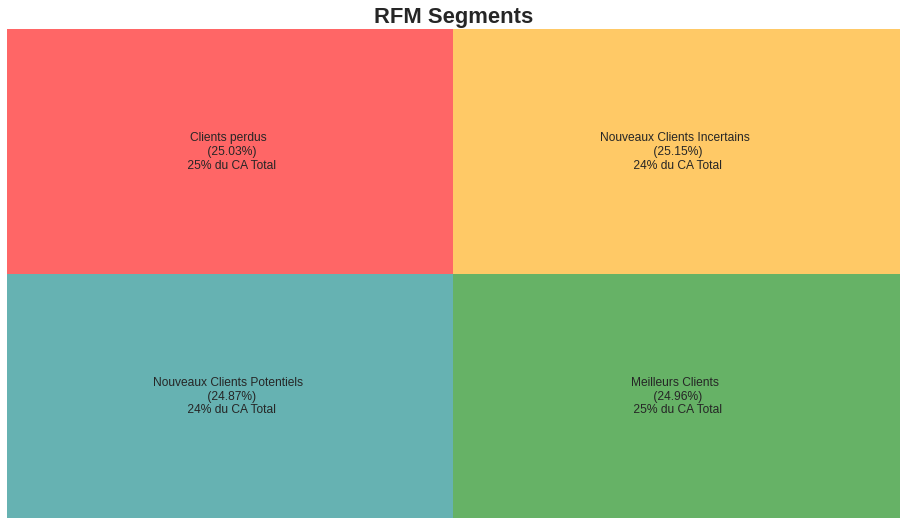

In [44]:
# Devise : Real Brésilien / 1$ = 5.19 Réal
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16,9)
perc = [f'{i/data_RFM.groupby("kmeans_label").count()["Recency"].sum()*100:5.2f}%' for i in data_RFM.groupby("kmeans_label").count()["Recency"]]
CA = (data_RFM.groupby("kmeans_label").sum()["Monetary"]  / data_RFM.groupby("kmeans_label").sum()["Monetary"].round(0).sum() * 100).round(2)
CA_clean=[]
for i in CA.tolist():
  CA_clean.append('{:,}% du CA Total'.format(int(i)).replace(',', ' '))
lbl = [f'{el[0]} \n ({el[1]})\n {el[2]}' for el in zip( data_RFM.groupby("kmeans_label")["Recency"].count().rename({0: "Nouveaux Clients Potentiels",
                                               1 : "Clients perdus",
                                               2 : "Meilleurs Clients",
                                               3: "Nouveaux Clients Incertains"},axis=0).index, perc,CA_clean)]
squarify.plot(sizes= data_RFM.groupby("kmeans_label")["Recency"].count(),
              label = lbl,
              
              color = ["Teal","Red","Green","Orange"],
              alpha=.6)
plt.title("RFM Segments", fontsize = 22, fontweight="bold")
plt.axis("off")
plt.show()

------

# **Segmentation sur nos données prétraitées (Feature Engineering)**

# Preprocessing 

Nous allons supprimer customer_zip_code_prefix et customer_city, customer_state pour ne conserver que la variable haversine_distance pour indiquer une localisation "large" des clients, ce qui évitera de focaliser la segmentation sur la localisation du client.

Nous allons également supprimer mean_price_order et mean_nb_items puisque nous avons vu dans le Notebook de nettoyage et exploration Olist que ces variables sont fortement corrélées aux totaux pour le moment.

In [45]:
data.drop(["customer_zip_code_prefix",
           "customer_city",
           "customer_state",
           "Flag and name",
           "mean_price_order",
           "mean_nb_items"], axis=1, inplace=True)

In [46]:
categorical_features = list(data.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns)
categorical_features

['customer_unique_id']

In [47]:
numerical_features = list(data.select_dtypes(include=['int64','float64', 'uint8']).columns)
numerical_features

['nb_orders',
 'total_spend',
 'mean_payment_sequential',
 'mean_payment_installments',
 'mean_review_score',
 'mean_delivery_days',
 'favorite_sale_month',
 'books_cds_media',
 'fashion_clothing_accessories',
 'flowers_gifts',
 'groceries_food_drink',
 'health_beauty',
 'home_furniture',
 'other',
 'sport',
 'technology',
 'toys_baby',
 'total_items',
 'recency',
 'order_mean_delay',
 'freight_ratio',
 'harvesine_distance']

On prepare ensuite le preprocessor :

In [48]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_features)])

Méthode du coude : détermination du meilleur K
Un pipeline SKLearn est créé pour y inclure le preprocessing et la visualisation de la méthode du coude de notre KMeans.

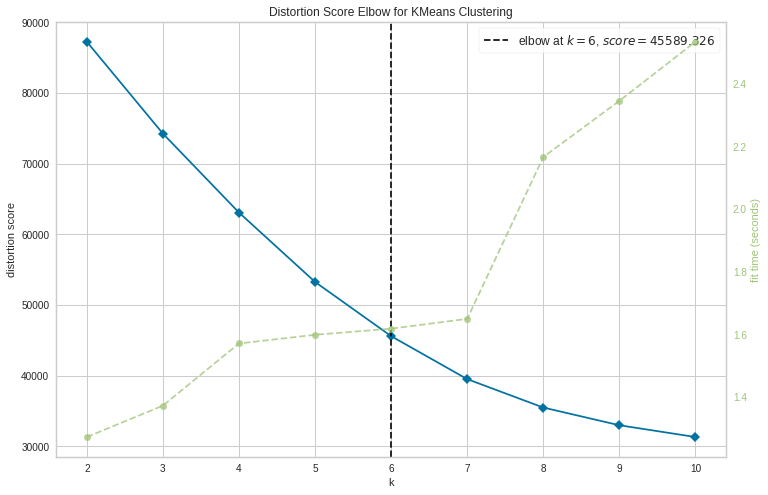

In [49]:
X = data.copy()
# Elbow method
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(4,12)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

Grâce à la méthode du coude basée sur le score de distortion (somme moyenne des carrés des distances aux centres), une segmentation en  K=6 clusters serait la meilleure option

# Coefficient de silhouette

Pour vérifier si ce clustering fonctionne, nous allons utiliser SilhouetteVisualizer pour afficher le coefficient de silhouette pour un échantillonage de chaque cluster. Cela permet de visualiser la densité et la séparation des clusters.

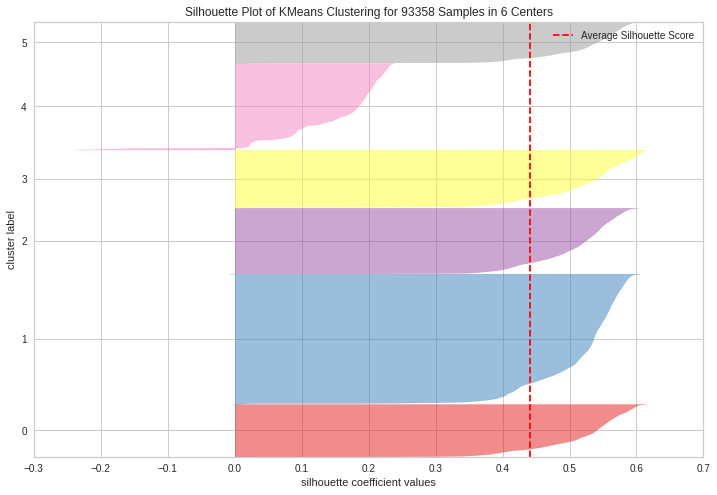

In [50]:
# Best K in Elbow
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_

# Silhouette Visualizer
silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

Le score de chaque échantillon est calculé en faisant la moyenne du coefficient de silhouette (différence entre la distance moyenne intra-cluster et la distance moyenne du cluster le plus proche pour chaque échantillon), normalisée par la valeur maximale. Cela nous donne un score entre -1 et 1, qui nous permet de déterminer si la séparation est efficace ou si les points sont assignés au mauvais cluster.

Ici, les clusters semblent relativement bien répartis et les séparations sont claires avec cependant quelques erreurs sur l'un des clusters.

A présent, nous allons tester d'autres types de métriques pour trouver le meilleur K :

* Silouhette : rapport moyen entre la distance intra-cluster et la distance du cluster le plus proche,
* Calinski Harabasz : rapport entre la dispersion des grappes dans et entre les groupes.

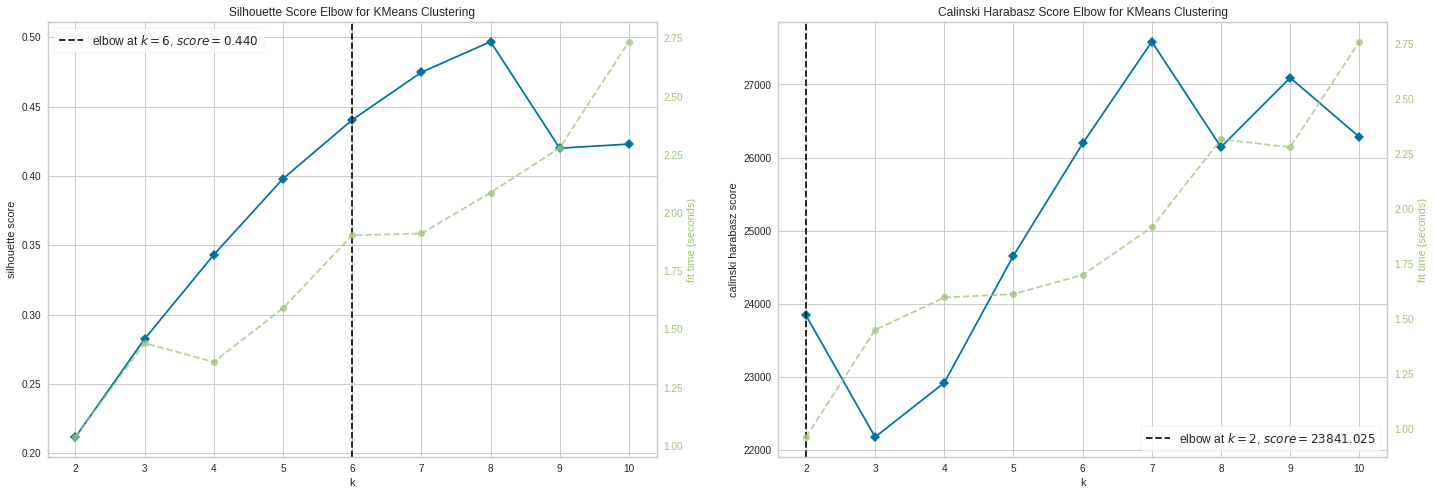

In [51]:
# Elbow method with differents metrics
metrics = ["silhouette", "calinski_harabasz"]
i = 0

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(24,8))
for m in metrics:
    kmeans_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("kelbowvisualizer", KElbowVisualizer(KMeans(),
                                              K=(4,10),
                                              metric=m,
                                              ax=axes[i]))])
    kmeans_visualizer.fit(X)
    kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
    i+=1

plt.show()

On remarque ici que pour la métrique silhouette score, le nombre de K est cette fois ci de 6. Pour le score Calinski Harabasz, le meilleur K est plus incertain. Les scores sur la répartition en 6 clusters semblent être meilleurs. Nous allons donc conserver ce clustering en 6 groupes

# Distances intercluster

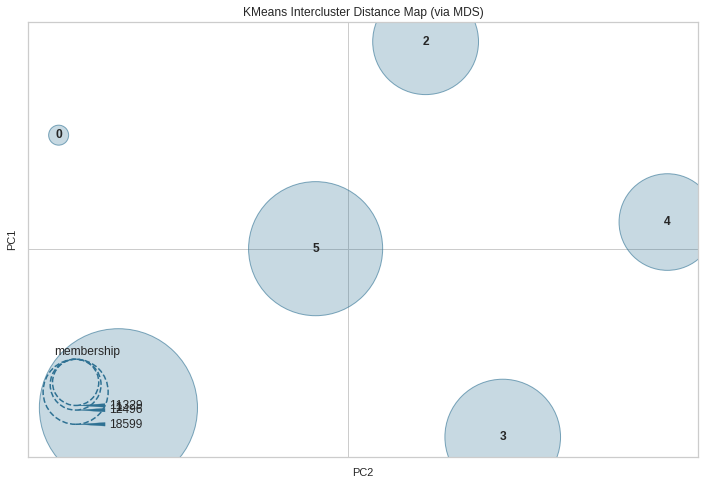

In [52]:
# Intercluster distance Map with best k
distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()

Sur cette projection en 2D, on remarque que les différents clusters sont bien séparés sur les 2 premières composantes principales. Le clustering semble donc performant et il faut a présent identifier les composantes métier de chaque cluster.

Analyse des différents clusters

A présent, nous allons entrainer notre KMeans avec le K optimal sélectionné et affecter son cluster à chaque client. Ainsi, nous pourrons analyser les différences entre chaque cluster :

In [53]:
# KMeans Pipeline with best K
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

# Kmeans labels
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
data["kmeans_label"] = kmeans_labels

Nous allons dans un premier temps grouper les individus par cluster pour analyser les moyennes :

In [54]:
kmeans_clusters_means = data.groupby("kmeans_label").mean().reset_index()
kmeans_clusters_means

,kmeans_label,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,books_cds_media,fashion_clothing_accessories,...,home_furniture,other,sport,technology,toys_baby,total_items,recency,order_mean_delay,freight_ratio,harvesine_distance
0,0,1.026552,178.773307,1.041247,2.837240,4.181324,12.152238,5.863404,0.000200,0.001180,...,0.004599,0.988958,0.000127,0.001802,0.000653,1.152271,340.989523,211.199576,0.204211,434.188665
1,1,1.022632,221.346216,1.042003,3.636342,4.172366,12.654672,6.269191,0.000114,0.000796,...,0.002066,0.001236,0.000061,0.001687,0.000477,1.086432,363.304788,234.517410,0.140103,485.062995
2,2,1.041615,147.065707,1.040280,2.675176,4.241839,11.913639,6.257648,0.045074,0.167981,...,0.004043,0.002008,0.386127,0.001450,0.341988,1.149202,376.489327,242.530694,0.203646,430.873567
3,3,1.021719,146.017088,1.036352,2.259793,4.096199,13.084968,5.695791,0.000035,0.000674,...,0.001607,0.000624,0.000053,0.995842,0.000094,1.153307,365.801981,236.596304,0.259895,472.068785
4,4,1.042077,163.741537,1.055785,3.289502,4.085000,12.973969,6.048257,0.000137,0.000700,...,0.993364,0.001749,0.000194,0.001430,0.000545,1.278147,370.993178,236.862449,0.216054,399.537467
5,5,1.029124,163.689024,1.034058,3.146538,4.247599,12.025858,6.065572,0.000177,0.000588,...,0.002390,0.000852,0.000099,0.001147,0.000081,1.127615,353.155238,222.103443,0.188541,464.239506


In [55]:
X.set_index("customer_unique_id",inplace = True)

In [56]:
X_scaled = preprocessor.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_scaled["kmeans_label"] = kmeans_labels
X_scaled_clusters = X_scaled.groupby("kmeans_label").mean()
X_scaled_clusters

,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,books_cds_media,fashion_clothing_accessories,flowers_gifts,...,home_furniture,other,sport,technology,toys_baby,total_items,recency,order_mean_delay,freight_ratio,harvesine_distance
kmeans_label,,,,,,,,,,,,,,,,,,,,,
0,0.001897,0.012390,0.001650,0.109125,0.795331,0.053360,0.442128,0.000200,0.001180,0.000904,...,0.004599,0.988958,0.000127,0.001802,0.000653,0.006620,0.304333,0.296213,0.212719,0.164561
1,0.001617,0.015508,0.001680,0.139859,0.793091,0.055764,0.479017,0.000114,0.000796,0.992669,...,0.002066,0.001236,0.000061,0.001687,0.000477,0.003758,0.335631,0.328916,0.145941,0.190271
2,0.002973,0.010068,0.001611,0.102891,0.810460,0.052218,0.477968,0.045074,0.167981,0.001853,...,0.004043,0.002008,0.386127,0.001450,0.341988,0.006487,0.354122,0.340155,0.212132,0.162886
3,0.001551,0.009991,0.001454,0.086915,0.774050,0.057823,0.426890,0.000035,0.000674,0.000462,...,0.001607,0.000624,0.000053,0.995842,0.000094,0.006666,0.339133,0.331832,0.270724,0.183705
4,0.003006,0.011289,0.002231,0.126519,0.771250,0.057292,0.458932,0.000137,0.000700,0.000964,...,0.993364,0.001749,0.000194,0.001430,0.000545,0.012093,0.346414,0.332205,0.225056,0.147050
5,0.002080,0.011286,0.001362,0.121021,0.811900,0.052755,0.460507,0.000177,0.000588,0.000559,...,0.002390,0.000852,0.000099,0.001147,0.000081,0.005548,0.321396,0.311506,0.196397,0.179748


Projetons à présent ces différentes moyennes sur un Radar plot avec la librairie Ploty pour visualiser les différences entre cluster :

In [57]:
plot_radars(data=X_scaled_clusters,
            group="kmeans_label")

Malheureusement ici, la segmentation se base principalement sur les catégories de produit achetées. Le poids de ces features masque les autres axes de catégorisation, nous allons donc réaliser un nouveau K-Means en supprimant ces variables (nous pourrons ensuite ajouter la valeur la plus fréquente pour chaque groupe)

# Clustering sans les catégories produits

In [58]:
categories_col = ['books_cds_media',
                  'fashion_clothing_accessories',
                  'flowers_gifts',
                  'groceries_food_drink',
                  'health_beauty',
                  'home_furniture',
                  'other',
                  'sport',
                  'technology',
                  'toys_baby']
X_bis = X.drop(categories_col, axis=1)
X_bis.head(6)

,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,total_items,recency,order_mean_delay,freight_ratio,harvesine_distance
customer_unique_id,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,1.0,8.0,5.0,6.0,5,1.0,236,111.0,0.08,209.713834
0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,1.0,1.0,4.0,3.0,5,1.0,239,114.0,0.30,209.713834
0000f46a3911fa3c0805444483337064,1,86.22,1.0,8.0,3.0,26.0,3,1.0,661,537.0,0.20,125.363853
0000f6ccb0745a6a4b88665a16c9f078,1,43.62,1.0,4.0,4.0,20.0,10,1.0,445,321.0,0.40,1574.231129
0004aac84e0df4da2b147fca70cf8255,1,196.89,1.0,6.0,5.0,13.0,11,1.0,412,288.0,0.09,209.713834
0004bd2a26a76fe21f786e4fbd80607f,1,166.98,1.0,8.0,4.0,2.0,4,1.0,270,146.0,0.08,209.713834


In [59]:
def clustering_eval(preprocessor, model, data, metric, elbow=True, mds=False, KBest=None):
    
    if((elbow==True) & (mds==True)):
        ncols=3
    elif((elbow==False) | (mds==False)):
        ncols=2
    else:
        ncols=1
        
    fig, axes = plt.subplots(nrows=1, ncols=ncols, sharex=False, sharey=False, figsize=(24,8))
    
    ax=0
    if(elbow==True):
        # Elbow visualizer
        kmeans_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("kelbowvisualizer", KElbowVisualizer(model,K=(4,12), metric=metric, ax=axes[ax]))])
        kmeans_visualizer.fit(data)
        KBest = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_
        kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
        ax+=1
    
    # Set best K
    K = KBest
    model.set_params(n_clusters=K)

    # Silhouette Visualizer
    silhouette_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("silhouettevisualizer", SilhouetteVisualizer(model, ax=axes[ax]))])
    silhouette_visualizer.fit(data)
    silhouette_visualizer.named_steps['silhouettevisualizer'].finalize()
    ax+=1
    
    # Intercluster distance Map with best k
    if(mds==True):
        distance_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("distancevisualizer", InterclusterDistance(model, ax=axes[ax]))])
        distance_visualizer.fit(data)
        distance_visualizer.named_steps['distancevisualizer'].finalize()
    
    return K
    plt.show()

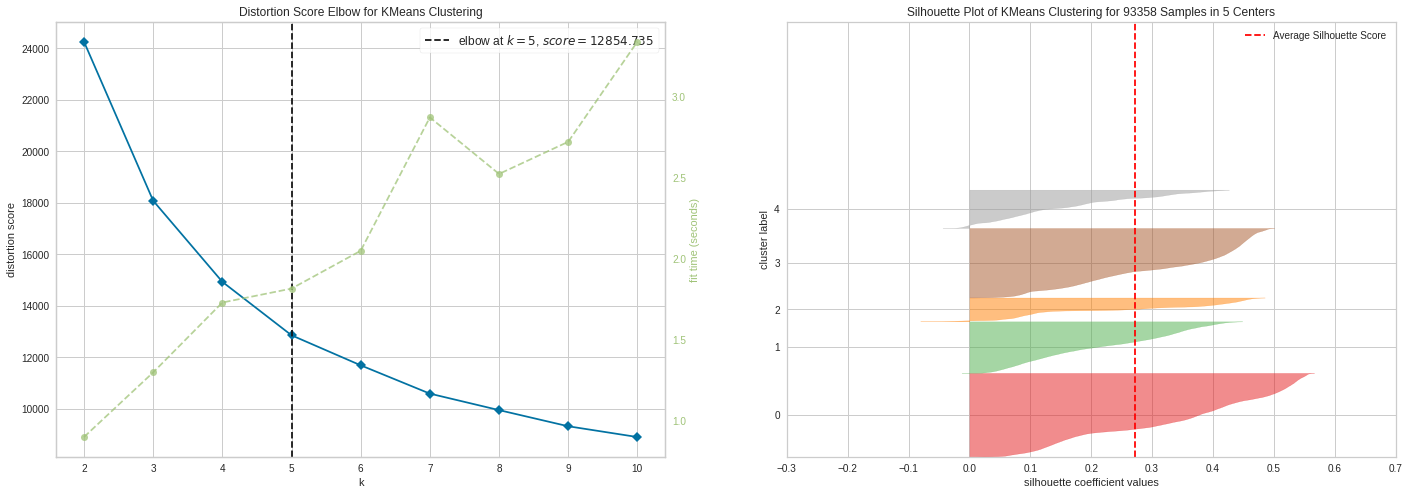

In [60]:
K = clustering_eval(preprocessor=MinMaxScaler(), 
                model=KMeans(), 
                data=X_bis, 
                metric="distortion",
                elbow=True,
                mds=False,
                KBest=None)

In [61]:
# KMeans Pipeline with best K
kmeans_model_bis = Pipeline([("preprocessor", MinMaxScaler()),
                             ("kmeans", KMeans(K))])
kmeans_model_bis.fit(X_bis)

# Kmeans labels
kmeans_labels_bis = kmeans_model_bis.named_steps['kmeans'].labels_

# Scale X
scaler = MinMaxScaler()
X_scaled_bis = scaler.fit_transform(X_bis)
X_scaled_bis = pd.DataFrame(X_scaled_bis, index=X_bis.index, columns=X_bis.columns)
X_scaled_bis["kmeans_label"] = kmeans_labels_bis

# Group by cluster
X_scaled_clusters_bis = X_scaled_bis.groupby("kmeans_label").mean()

# Plot Radar chart
plot_radars(data=X_scaled_clusters_bis,
            group="kmeans_label")

# Interprétation rapide métier des clusters

* **Groupe 0** : Clients proches géographiquement avec de courts délais de livraison mais avec un frais de port élevé, leur nombre de commandes passées sur le site est moyen et avec peu d'articles. Ils achètent principalement en milieu d'année pour des montants faibles. Ils paient avec 1 type de moyen de paiement voire 2. Les avis de ces clients sont très bons.
* **Groupe 1** : Clients de début d'année. Ils règlent avec plusieurs moyens de paiement et en plusieurs fois pour des montants faibles. Ces clients sont géographiquement peu éloignés et les délais de livraison sont courts. Les avis de ces clients sont également très bons. Mais Ils ont tendance à espacer les délais entre 2 commandes. Clients anciens.
* **Groupe 3** : Clients proches géographiquement avec de courts délais de livraison et un frais de port bas, ayant commandé plusieurs fois principalement en fin d'année pour des montants faibles. Ils paient avec plusieurs types de moyen de paiement et avec au maximum 2 échéances. Les avis de ces clients sont très bons. Ils ont tendance à espacer les délais entre 2 commandes.
* **Groupe 4** : Regroupe les clients de début d'année qui paient comptant pour des montants faibles. Les avis de ces clients sont également très bons. Ils sont géographiquement assez proches. Clients récents
* **Groupe 2** : Ce sont des clients mécontents (les avis sont mauvais). Regroupe les clients qui utilisent plusieurs moyens de paiement et un nombre moyen d'échéances. Les délais de livraison sont très importants et les frais de port élevés en raison de l'éloignement géographique. Ce sont cependant les clients qui ont le plus dépensé et ont acheté un grand nombre d'articles. En revanche, le nombre de commandes passées sur le site est moyen. Clients insatisfaits


Nous allons à présent réaliser une réduction dimensionnelle pour vérifier si le clustering est réalisable sur un nombre réduit de variables sans perturber les groupes

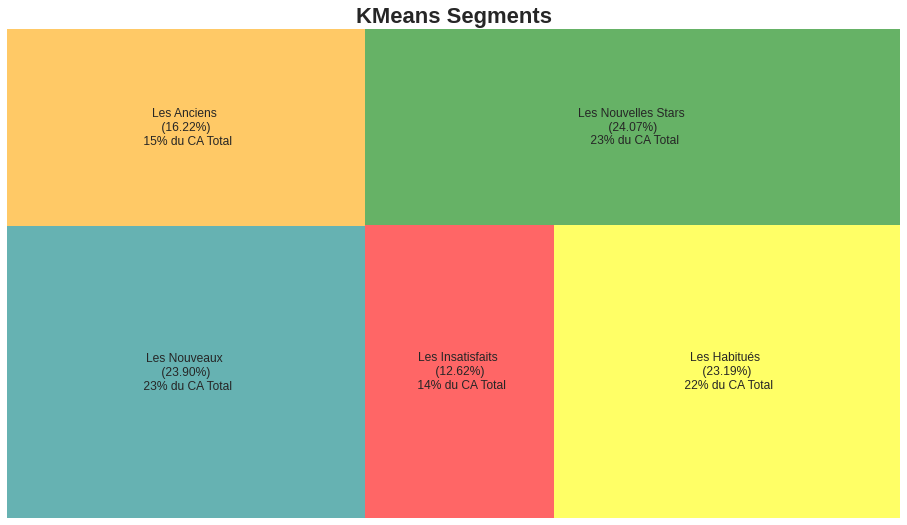

In [292]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16,9)
perc = [f'{i/X_scaled_bis.groupby("kmeans_label").count()["nb_orders"].sum()*100:5.2f}%' for i in X_scaled_bis.groupby("kmeans_label").count()["nb_orders"]]
X_bis["kmeans_label"] = kmeans_labels_bis

CA = (X_bis.groupby("kmeans_label").sum()["total_spend"]  / X_bis.groupby("kmeans_label").sum()["total_spend"].round(0).sum() * 100).round(2)
CA_clean=[]
for i in CA.tolist():
  CA_clean.append('{:,}% du CA Total'.format(int(i)).replace(',', ' '))
lbl = [f'{el[0]} \n ({el[1]}) \n {el[2]}' for el in zip( X_scaled_bis.groupby("kmeans_label")["nb_orders"].count().rename({
                                               0: "Les Nouveaux",
                                               1 : "Les Anciens",
                                               2 : "Les Insatisfaits",
                                               3: "Les Habitués",
                                               4: "Les Nouvelles Stars"},axis=0).index, perc,CA_clean)]
squarify.plot(sizes= X_scaled_bis.groupby("kmeans_label")["nb_orders"].count(),
              label = lbl,
              
              color = ["Teal","Orange","Red","Yellow","Green"],
              alpha=.6)
plt.title("KMeans Segments", fontsize = 22, fontweight="bold")
plt.axis("off")
plt.show()

# Réduction dimensionnelle - PCA

Nous allons réaliser une Analyse en Composantes Principales pour vérifier s'il est possible de catégoriser nos clients avec moins de variables. L'objectif étant de conserver une inertie de 95%

In [152]:
# PCA Pipeline
pca = Pipeline([("preprocessor", MinMaxScaler()),
                ("pca", PCA(svd_solver='full'))])
pca.fit(X_bis.drop(["kmeans_label","kmeans_label_pca"],axis=1))
X_projected = pca.transform(X_bis.drop(["kmeans_label","kmeans_label_pca"],axis=1))

## Eboulis des valeurs propres

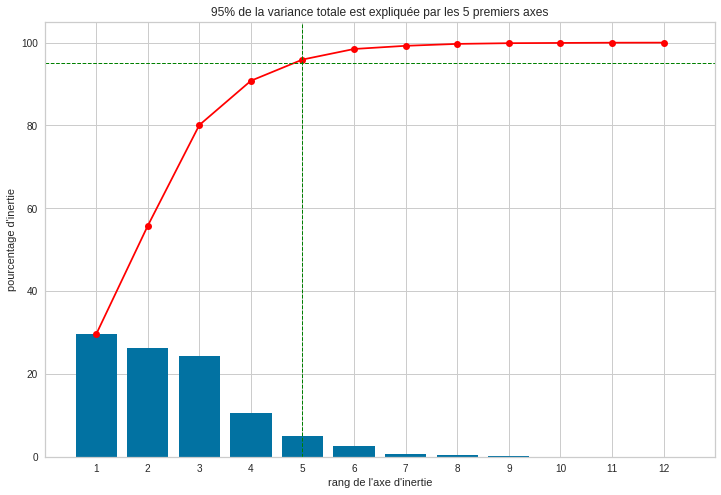

In [153]:
# Explained variance
varexpl = pca.named_steps['pca'].explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

Il faut donc conserver 5 axes principaux pour expliquer la variance à 95%

# Cercle des corrélations

In [154]:
def cerle_corr(pcs, n_comp, pca, axis_ranks, 
               labels=None, label_rotation=0):
    
    fig=plt.figure(figsize=(20,n_comp*5))
    count=1
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            
            # initialisation de la figure
            #fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
            ax=plt.subplot(int(n_comp/2),2,count)
            ax.set_aspect('equal', adjustable='box') 
            
            #détermination des limites du graphique
            ax.set_xlim(-1,1) 
            ax.set_ylim(-1,1) 

            #affichage des flèches 
            ax.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                       pcs[d1,:],pcs[d2,:], 
                       angles='xy', scale_units='xy', scale=1, 
                       color="grey", alpha=0.5)
            # et noms de variables
            for i,(x,y) in enumerate(pcs[[d1,d2]].T):
                ax.annotate(labels[i],(x,y),
                             ha='center', va='center',
                             fontsize='14',color="#17aafa", alpha=0.8) 

            #ajouter les axes 
            ax.plot([-1,1],[0,0],linewidth=1, color='grey', ls='--') 
            ax.plot([0,0],[-1,1],linewidth=1, color='grey', ls='--')

            #ajouter un cercle 
            cercle = plt.Circle((0,0),1,color='#17aafa',fill=False) 
            ax.add_artist(cercle) 

            # nom des axes, avec le pourcentage d'inertie expliqué
            ax.set_xlabel('F{} ({}%)'.format(d1+1, 
                                          round(100*pca.explained_variance_ratio_[d1],1)))
            ax.set_ylabel('F{} ({}%)'.format(d2+1, 
                                          round(100*pca.explained_variance_ratio_[d2],1)))

            ax.set_title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            count+=1
            
    plt.suptitle("Cercles des corrélations sur les {} premiers axes".format(n_comp),
                 y=.9, color="blue", fontsize=18)        
    plt.show(block=False)

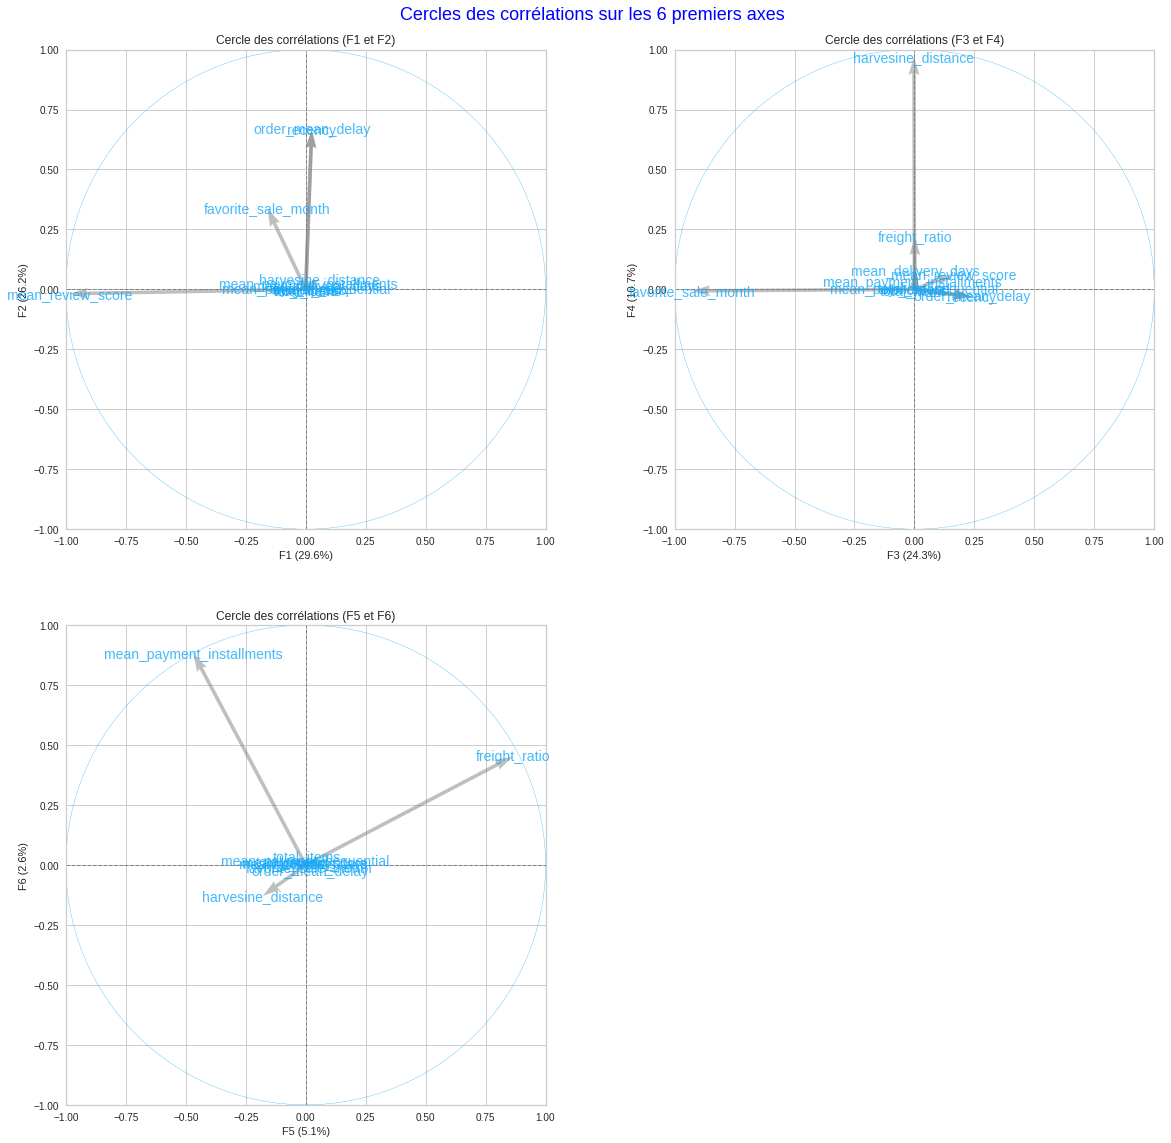

In [155]:
# Principal component space
pcs = pca.named_steps['pca'].components_

# Plot correlation circle
cerle_corr(pcs,
           6,
           pca.named_steps['pca'],
           [(0,1),(2,3),(4,5)],
           labels = np.array(X_bis.drop("kmeans_label",axis=1).columns))

On peut ainsi voir parfaitement les variables qui contribuent le plus à chaque axe. Par exemple, 

* la variable synthétique F2 représentera les périodes d'achats.

* La variable synthétique F4 quant à elle représente l'aspect géographique.

Nous allons donc intégrer à notre pipeline Kmeans une PCA sur 5 composantes pour vérifier si la réduction dimensionnelle réduit la qualité de la segmentation 

# K-Means après réduction de dimensions

In [159]:
# KMeans Pipeline with best K for PCA results
kmeans_model_pca = Pipeline([("preprocessor", MinMaxScaler()),
                             ("kmeans", KMeans(K))])
kmeans_model_pca.fit(X_projected[:,:4])

# Kmeans labels
pca_kmeans_labels = kmeans_model_pca.named_steps['kmeans'].labels_
X_scaled_bis["kmeans_label_pca"] = pca_kmeans_labels
X_scaled_clusters_pca = X_scaled_bis.groupby("kmeans_label_pca").mean()
X_scaled_clusters_pca.iloc[:,:-1]

,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,total_items,recency,order_mean_delay,freight_ratio,harvesine_distance
kmeans_label_pca,,,,,,,,,,,,
0,0.002123,0.011354,0.001428,0.109041,0.915440,0.037480,0.501060,0.006574,0.088467,0.082358,0.220280,0.154898
1,0.000608,0.010933,0.002374,0.123112,0.892778,0.052173,0.347780,0.005350,0.674215,0.670378,0.218848,0.172269
2,0.002144,0.013463,0.001879,0.124066,0.063672,0.091784,0.436958,0.015426,0.334024,0.323693,0.222046,0.190701
3,0.003203,0.010889,0.001596,0.105086,0.880665,0.056277,0.142669,0.007177,0.259546,0.243365,0.214645,0.157320
4,0.003163,0.011151,0.001756,0.116902,0.893660,0.053737,0.834817,0.007393,0.438384,0.422264,0.211305,0.169083


In [164]:
plot_radars(data=X_scaled_clusters_pca.iloc[:,:-1],
            group="kmeans_label_pca")

# Interprétation métier des clusters

0. * **`Les Stars`** : Nouveaux Clients proches géographiquement avec de courts délais de livraison mais avec un frais de port élevé, commande sur le site peu d'articles. Ils ont acheté en milieu d'année pour des montants faibles. Ils paient en une fois avec plusieurs types de moyen de paiement. Les avis de ces clients sont très bons. Ils sont intéressés surtout pour **l'aménagement de la maison et les produits de beauté**. *Ce groupe de client obtient la note moyenne la plus élevée dans mon classement. Il nécessite sans doute une attention toute particulière.*

1. * **`Les Clients Perdus`** : Clients assez éloignés géographiquement avec de courts délais de livraison mais un frais de port assez élevé, leur nombre de commande passé sur le site est faible et se situe principalement en début d'année pour des montants faible. Ils paient avec plusieurs type de moyen de paiement et en plusieurs fois. Les avis de ces clients sont bons. Mais Ils ont tendance à espacer les délais entre 2 commandes. Leur dernière commande date d'il y a 2 ans. Ils sont intéressés surtout pour **l'aménagement de la maison et les produits high tech**. *Ce groupe de client obtient la note moyenne la plus basse dans mon classement. Il nécessite sans doute une attention toute particulière.*
2. * **`Les Insatisfaits`** : Ce sont des clients mécontents (les avis sont mauvais). Regroupe les clients qui utilisent plusieurs moyens de paiement et un nombre moyen d'échéances. Les délais de livraison sont très importants et les frais de port élevés en raison de l'éloignement géographique. Ce sont cependant les clients qui ont le plus dépensé et ont acheté un grand nombre d'articles. En revanche, le nombre de commandes passées sur le site est moyen. Ils sont intéressés surtout pour **l'aménagement de la maison et les produits high tech**.
3. * **`Les Nouveaux`** : Nouveaux Clients (< 6 mois) de début d'année. Ils règlent comptant pour des montants faibles. Ces clients sont géographiquement peu éloignés et les délais de livraison sont courts. Les avis de ces clients sont également très bons. Ils comptent parmi ceux qui commandent le plus alors qu'ils sont nouveaux. Ils sont intéressés surtout pour **l'aménagement de la maison et les produits high tech**. *Futurs gros acheteurs*
4. * **`Les Habitués`** : Clients proches géographiquement avec de courts délais de livraison et un frais de port bas, ayant commandé plusieurs fois principalement en fin d'année pour des montants faibles. Ils paient avec plusieurs types de moyen de paiement et avec au maximum 2 échéances. Les avis de ces clients sont très bons. Ils sont intéressés surtout pour **l'aménagement de la maison, les produits high tech et les produits de beauté**.


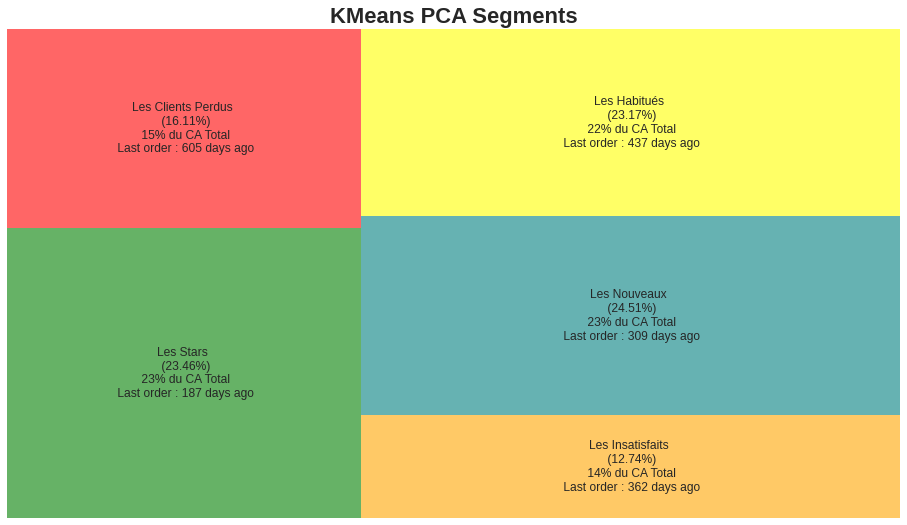

In [283]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16,9)
perc = [f'{i/X_scaled_bis.groupby("kmeans_label_pca").count()["nb_orders"].sum()*100:5.2f}%' for i in X_scaled_bis.groupby("kmeans_label_pca").count()["nb_orders"]]
X_bis["kmeans_label_pca"] = pca_kmeans_labels
Recency = X_bis.groupby("kmeans_label_pca").mean()["recency"].round(0)
CA = (X_bis.groupby("kmeans_label_pca").sum()["total_spend"]  / X_bis.groupby("kmeans_label_pca").sum()["total_spend"].round(0).sum() * 100).round(2)

CA_clean=[]
for i in CA.tolist():
  CA_clean.append('{:,}% du CA Total'.format(int(i)).replace(',', ' '))
lbl = [f'{el[0]} \n ({el[1]})\n {el[2]}\n Last order : {int(el[3])} days ago' for el in zip( X_scaled_bis.groupby("kmeans_label_pca")["nb_orders"].count().rename({
                                               0: "Les Stars",
                                               1 :"Les Clients Perdus",
                                               2 :"Les Insatisfaits",
                                               3: "Les Nouveaux",
                                               4: "Les Habitués"},axis=0).index, perc,CA_clean,Recency)]
squarify.plot(sizes= X_scaled_bis.groupby("kmeans_label_pca")["nb_orders"].count(),
              label = lbl,
              
              color = ["Green","Red","Orange","Teal","Yellow"],
              alpha=.6)
plt.title("KMeans PCA Segments", fontsize = 22, fontweight="bold")
plt.axis("off")
plt.show()

In [235]:
def rate_cluster(data):
  describe = data.describe()
  p10 = data.quantile(0.1)
  p90 = data.quantile(0.9)
  def rate(x):
    if x < p10:
      return ''
    elif p10 <= x < describe.loc['25%']:
      return '*'
    elif describe.loc['25%'] <= x < describe.loc['50%']:
      return '**'
    elif describe.loc['50%'] <= x < describe.loc['75%']:
      return '***'
    elif describe.loc['75%'] <= x < p90:
      return '****'
    elif x >= p90 :
      return '*****'

  return data.apply(rate)

##### Interprétation et similarités/différences entre clusters

Après avoir analysé l'ensemble des indicateurs, nous pouvons tenter **une interprétation des classes** trouvées. Pour cela, j'ai mis en place un système automatique de notation par étoiles. 

Je vais également chercher à mesurer la **différence entre les clusters** afin de comprendre les profils des clients qui les composent.

Je terminerai par la rédaction d'une **description actionnable et compréhensible** par les équipes marketing.

In [270]:
def interpretation_cluster(df, group='kmeans_label_pca',clust=0):
  CA = (df.groupby(group).sum()["total_spend"]  / df.groupby(group).sum()["total_spend"].round(0).sum() * 100).round(2)
  categ_stat = data.merge(df,how="inner",on ="customer_unique_id")[categories_col + [group]].groupby(group).sum()

  clusters_interpretation = {

    '% Chiffre Affaire': rate_cluster(CA).to_dict(),
    'Montant des Dépenses': rate_cluster(df.groupby(group).describe()['total_spend']['mean']).to_dict(),
    'Nombre de commandes': rate_cluster(df.groupby(group).describe()['nb_orders']['mean']).to_dict(),
    "Nombre d'articles": rate_cluster(df.groupby(group).describe()['total_items']['mean']).to_dict(),
    'Nouveaux clients': rate_cluster(-df.groupby(group).describe()['recency']['mean']).to_dict(),
    'Durée livraison': rate_cluster(-df.groupby(group).describe()['mean_delivery_days']['mean']).to_dict(),
    'Satisfaction': rate_cluster(df.groupby(group).describe()['mean_review_score']['50%']).to_dict(),
    'Top 3 Catégories': {i: [f'{k + 1}#: {v}' for k,v in enumerate(categ_stat.loc[i].nlargest(3).sort_values(ascending=False).index[:3])] for i in range(0+clust,5+clust)},
    'Flop 3 Catégories': {i: [f'{k + 1}#: {v}' for k,v in enumerate(categ_stat.loc[i].nsmallest(3).sort_values(ascending=True).index[:3])] for i in range(0+clust,5+clust)},
    'Paiement en x fois': rate_cluster(-df.groupby(group).describe()['mean_payment_sequential']['mean']).to_dict(),
    'Nb Moyens de Paiement': rate_cluster(-df.groupby(group).describe()['mean_payment_installments']['mean']).to_dict(),
  }
  interpretation = pd.DataFrame(clusters_interpretation)

  return interpretation 


In [271]:
interpretation_cluster(X_bis, group='kmeans_label_pca')

,% Chiffre Affaire,Montant des Dépenses,Nombre de commandes,Nombre d'articles,Nouveaux clients,Durée livraison,Satisfaction,Top 3 Catégories,Flop 3 Catégories,Paiement en x fois,Nb Moyens de Paiement
0,****,****,**,**,*****,*****,*****,"[1#: home_furniture, 2#: other, 3#: health_bea...","[1#: books_cds_media, 2#: groceries_food_drink...",*****,****
1,**,**,,,,****,*****,"[1#: home_furniture, 2#: technology, 3#: healt...","[1#: groceries_food_drink, 2#: books_cds_media...",,**
2,,*****,***,*****,***,,,"[1#: home_furniture, 2#: technology, 3#: other]","[1#: books_cds_media, 2#: groceries_food_drink...",**,
3,*****,,*****,***,****,**,*****,"[1#: home_furniture, 2#: technology, 3#: other]","[1#: books_cds_media, 2#: groceries_food_drink...",****,*****
4,***,***,****,****,**,***,*****,"[1#: home_furniture, 2#: technology, 3#: healt...","[1#: books_cds_media, 2#: groceries_food_drink...",***,***


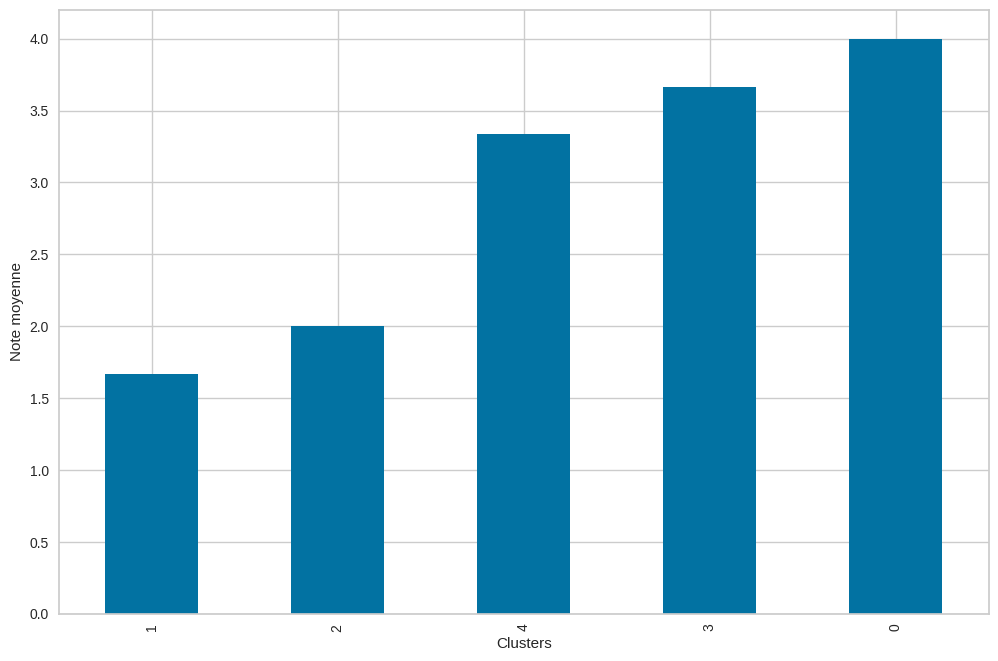

In [272]:
def plt_note_cluster(interpretation= interpretation_cluster(X_bis, group='kmeans_label_pca')):
  plt.figure(dpi=100)
  interpretation.replace({stars * '*': stars for stars in range(0,6)}).mean(axis=1).sort_values().plot(kind='bar')
  plt.xlabel('Clusters')
  plt.ylabel('Note moyenne')
 
plt_note_cluster()

5

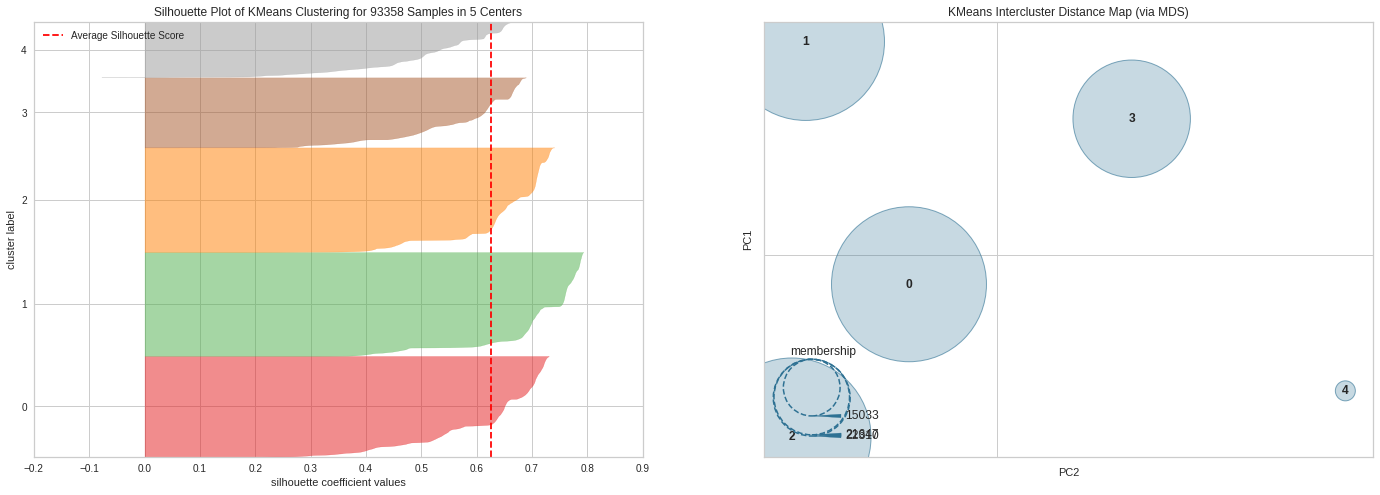

In [71]:
clustering_eval(preprocessor=MinMaxScaler(), 
                model=KMeans(), 
                data=X_projected[:,:4], 
                metric="distortion",
                elbow=False,
                mds=True,
                KBest=K)

On remarque donc ici que la réduction de dimension offre les mêmes axes de segmentation. Il est donc possible de réduire le nombre de features en entrée et d'utiliser les variables synthétiques de la PCA pour segmenter notre fichier client, d'autant plus que les scores silhouette sont ici meilleurs comparés au données brutes.

# Stabilité à l'initialisation du K-Means

Notre algorithme du K-Means testé ici est initialisé avec la méthode K-Means++, ce qui réduit déjà les effets aléatoires de l'initialisation des centroïdes. Cependant, nous allons tester la stabilité à l'initialisation en entrainant plusieurs fois le modèle sans fixer le RandomState.

Pour les labels initiaux, nous allons conserver les clusters calculés dans le dernier modèle (avec PCA) puis les comparer grâce à l'indice de Rand ajusté (ARI) pour chacune des itérations.

In [72]:
labels = pca_kmeans_labels
pca_data = X_projected[:,:4]

In [73]:
def bench_k_means(model, name, data, labels):
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), model).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[1].inertia_]
    
    # Test differents metrics on pred labels
    clustering_metrics = [
        homogeneity_score,
        adjusted_rand_score,
        adjusted_mutual_info_score]
    results += [m(labels, estimator[1].labels_) for m in clustering_metrics]
    
    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [74]:
print("Scores de stabilité à l'initialisation")
print(53 * '_')
print('Iteration\tFitTime\tInertia\tHomo\tARI\tAMI')
print(53 * '_')

for i in range(10):
    imodel = KMeans(n_clusters=K, n_init=1, init="k-means++")
    bench_k_means(model = imodel, name="Iter "+str(i), 
                  data=pca_data, labels=labels)

print(53 * '_')

Scores de stabilité à l'initialisation
_____________________________________________________
Iteration	FitTime	Inertia	Homo	ARI	AMI
_____________________________________________________
Iter 0   	0.112s	3453	1.000	1.000	1.000
Iter 1   	0.119s	3453	1.000	1.000	1.000
Iter 2   	0.112s	3453	1.000	1.000	1.000
Iter 3   	0.126s	3453	1.000	1.000	1.000
Iter 4   	0.114s	3453	1.000	1.000	1.000
Iter 5   	0.106s	3453	1.000	1.000	1.000
Iter 6   	0.105s	3453	1.000	1.000	1.000
Iter 7   	0.159s	3453	1.000	1.000	1.000
Iter 8   	0.127s	3453	1.000	1.000	1.000
Iter 9   	0.289s	5356	0.792	0.756	0.823
_____________________________________________________


Les différentes itérations montrent des inerties proches, une bonne homogénéité et un score AMI proche de 1. Nous pouvons donc en déduire que la stabilité à l'initialisation du modèle K-Means est bonne

# Stabilité temporelle de la segmentation


Dans le but d'établir un contrat de maintenance de l'algorithme de segmentation client, nous devons tester sa stabilité dans le temps et voir, par exemple, à quel moment les clients changent de Cluster.

Pour cela, nous devons recalculer toutes les features en fonction d'une période donnée. Le script réalisant ces calculs est disponible dans le module annexe P5_olist_functions

In [75]:
# Initial period of 12 months
data_init = func_olist.make_dataset(dpath=root_path, initial=True, period=2)

Création du dataset en cours ...
______________________________________________________
Features engineering effectué sur  12 mois :
______________________________________________________
Durée d'execution du Feature engineering : 22.38s


In [76]:
# Remove categories
data_init.drop(categories_col, axis=1, inplace=True)
data_init.head(6)

,nb_orders,total_items,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,order_mean_delay,freight_ratio,haversine_distance
customer_unique_id,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,1,1,86.22,1.0,8.0,3.0,26.0,3,178.0,0.20,125.363853
0005e1862207bf6ccc02e4228effd9a0,1,1,150.12,1.0,3.0,4.0,4.0,3,184.0,0.10,428.916514
0006fdc98a402fceb4eb0ee528f6a8d4,1,1,29.00,1.0,2.0,3.0,16.0,7,48.0,0.52,669.215559
000a5ad9c4601d2bbdd9ed765d5213b3,1,1,91.28,1.0,3.0,4.0,11.0,8,24.0,0.16,337.899660
000de6019bb59f34c099a907c151d855,1,2,257.44,1.0,4.0,2.0,2.0,8,18.0,0.11,209.713834
0010a452c6d13139e50b57f19f52e04e,1,1,325.93,1.0,10.0,1.0,15.0,7,55.0,0.08,337.899660


Nous allons ensuite déterminer la période totale à couvrir 

In [77]:
orders = pd.read_csv(root_path+"olist_orders_dataset.csv")
orders = orders.loc[orders.order_status == "delivered", 
                    "order_purchase_timestamp"]
orders = pd.to_datetime(orders)
time_delta = int((orders.max() - orders.min())/np.timedelta64(1,'M'))
print("La période complète des commandes porte sur {} mois.".format(time_delta))

La période complète des commandes porte sur 23 mois.


Pour déterminer le moment où les clients changent de cluster, nous allons itérer le K-Means sur toute la période avec des deltas de 2 mois et calculer le score ARI, en prenant garde à bien comparer les mêmes clients (ceux des 12 mois initiaux).

Ici le déroulé est créé directement dans le notebook pour explication, en production, toutes ses opérations seront regroupées dans une classe Python pour automatiser le processus.

In [78]:
features_to_fill = data_init.isnull().sum()
features_to_fill = list(features_to_fill[features_to_fill.values > 0].index)
for f in features_to_fill:
        data_init[f] = data_init[f].fillna(data_init[f].mode()[0])

In [79]:
K=4

In [80]:
# Kmeans on initial period
kmeans_init = Pipeline([("preprocessor", MinMaxScaler()),
                        ("kmeans", KMeans(K, random_state=42))])
kmeans_init.fit(data_init)
init_labels = kmeans_init.named_steps['kmeans'].labels_

In [81]:
ari_score = []

for p in np.arange(2,(time_delta-12),2):
    # Create dataset for period
    data_period = func_olist.make_dataset(dpath=root_path, 
                                   initial=False, 
                                   period=p)
    features_to_fill = data_period.isnull().sum()
    features_to_fill = list(features_to_fill[features_to_fill.values > 0].index)
    for f in features_to_fill:
        data_period[f] = data_period[f].fillna(data_period[f].mode()[0])
    data_period.drop(categories_col, axis=1, inplace=True)
    
    # Filter on initial customer client
    data_period = data_period[data_period.index.isin(data_init.index)]
    
    # K-Means
    kmeans_p = Pipeline([("preprocessor", MinMaxScaler()),
                         ("kmeans", KMeans(K, random_state=42))])
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_
    
    # Calculate ARI score
    ari_p = adjusted_rand_score(init_labels, kmeans_p[1].labels_)
    ari_score.append([p,ari_p])

Création du dataset en cours ...
______________________________________________________
Features engineering effectué sur  14 mois :
______________________________________________________
Durée d'execution du Feature engineering : 24.17s
Création du dataset en cours ...
______________________________________________________
Features engineering effectué sur  16 mois :
______________________________________________________
Durée d'execution du Feature engineering : 32.54s
Création du dataset en cours ...
______________________________________________________
Features engineering effectué sur  18 mois :
______________________________________________________
Durée d'execution du Feature engineering : 42.45s
Création du dataset en cours ...
______________________________________________________
Features engineering effectué sur  20 mois :
______________________________________________________
Durée d'execution du Feature engineering : 52.18s
Création du dataset en cours ...
_______________

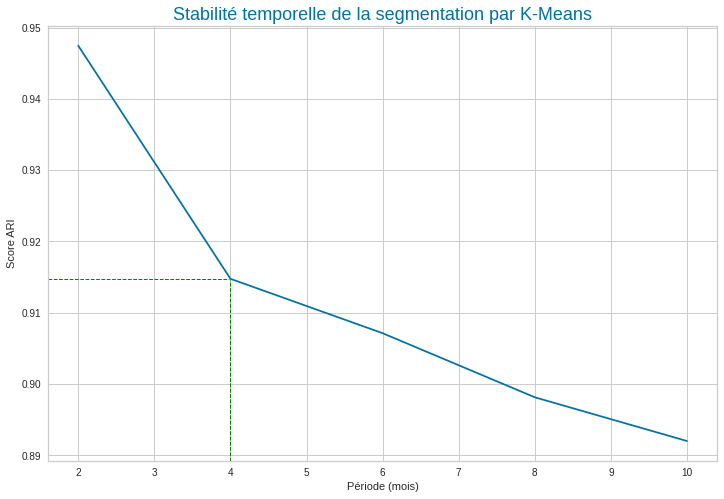

In [82]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.axhline(y=ari_score.iloc[1][1], linestyle="--", 
            color="green",
            xmax=0.27,
            linewidth=1)
plt.axvline(x=ari_score.iloc[1][0], linestyle="--", 
            color="green",
            ymax=1.33-(ari_score.iloc[1][1]),
            linewidth=1)
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

Sur ce plot des scores ARI obtenus sur les itérations par période de 2 mois, on remarque une forte inflexion après 4 mois sur les clients initiaux.

Il faudra donc prévoir la maintenance du programme de segmentation tous les 4 mois dans un premier temps puis re-tester cette stabilité temporelle au fil du temps afin de l'affiner. Il sera donc nécessaire de redéfinir les segments clients à chaque maintenance.

# **CAH sur echantillon (car dataset de plus de 93000 observations)**

### Classification ascendante hiérarchique


## **Classification ascendante hiérarchique**
   ### Utilisation du package « scipy »


In [83]:
categories_col = ['books_cds_media',
                  'fashion_clothing_accessories',
                  'flowers_gifts',
                  'groceries_food_drink',
                  'health_beauty',
                  'home_furniture',
                  'other',
                  'sport',
                  'technology',
                  'toys_baby',
                  'kmeans_label'
                 ]
data_bis = data.drop(categories_col ,axis = 1)

In [84]:
data_bis.set_index("customer_unique_id", inplace=True)

In [85]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, data_bis)])

In [86]:
X = data_bis.copy()
X.head(10)

,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,total_items,recency,order_mean_delay,freight_ratio,harvesine_distance
customer_unique_id,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,1.0,8.0,5.0,6.0,5,1.0,236,111.0,0.08,209.713834
0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,1.0,1.0,4.0,3.0,5,1.0,239,114.0,0.30,209.713834
0000f46a3911fa3c0805444483337064,1,86.22,1.0,8.0,3.0,26.0,3,1.0,661,537.0,0.20,125.363853
0000f6ccb0745a6a4b88665a16c9f078,1,43.62,1.0,4.0,4.0,20.0,10,1.0,445,321.0,0.40,1574.231129
0004aac84e0df4da2b147fca70cf8255,1,196.89,1.0,6.0,5.0,13.0,11,1.0,412,288.0,0.09,209.713834
0004bd2a26a76fe21f786e4fbd80607f,1,166.98,1.0,8.0,4.0,2.0,4,1.0,270,146.0,0.08,209.713834
00050ab1314c0e55a6ca13cf7181fecf,1,35.38,1.0,1.0,4.0,7.0,4,1.0,255,131.0,0.21,209.713834
00053a61a98854899e70ed204dd4bafe,1,419.18,1.0,3.0,1.0,16.0,2,2.0,307,182.0,0.09,108.557249
0005e1862207bf6ccc02e4228effd9a0,1,150.12,1.0,3.0,4.0,4.0,3,1.0,667,543.0,0.10,428.916514


In [87]:
#  Preprocessing the data

# Scaling the data to bring all the attributes to a comparable level
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
  
# Normalizing the data so that 
# the data approximately follows a Gaussian distribution
X_normalized = normalize(X_scaled)
  
# Converting the numpy array into a pandas DataFrame
X_normalized = pd.DataFrame(X_normalized)

In [88]:
# PCA Pipeline
pca = PCA(svd_solver='full')
pca.fit(X_normalized)
X_projected = pca.transform(X_normalized)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[0.25671981 0.14601226 0.13693266 0.13340647 0.09013387 0.07334788
 0.04914479 0.04520283 0.02093013 0.01853232 0.01709898 0.00030818]
[0.25989832 0.14782008 0.13862805 0.13505821 0.09124984 0.07425602
 0.04975326 0.0457625  0.02118927 0.01876178 0.01731068 0.00031199]


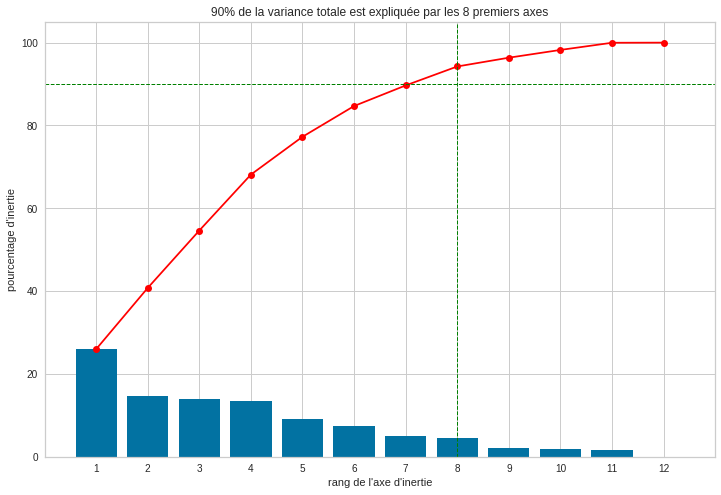

In [89]:
# Explained variance

varexpl = pca.explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=90, linestyle="--", 
            color="green",
            linewidth=1)

limit = 90
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

In [90]:
#  Réduire la dimensionnalité des Données
n_components= 8
pca = PCA(n_components = n_components,svd_solver='full')
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = [f"P{i}" for i in range(1,n_components+1)]

In [91]:
import numpy as np
from sklearn.model_selection import train_test_split

In [92]:
 X_train, X_test  = train_test_split(
                     X_principal,  test_size=0.8, random_state=0)

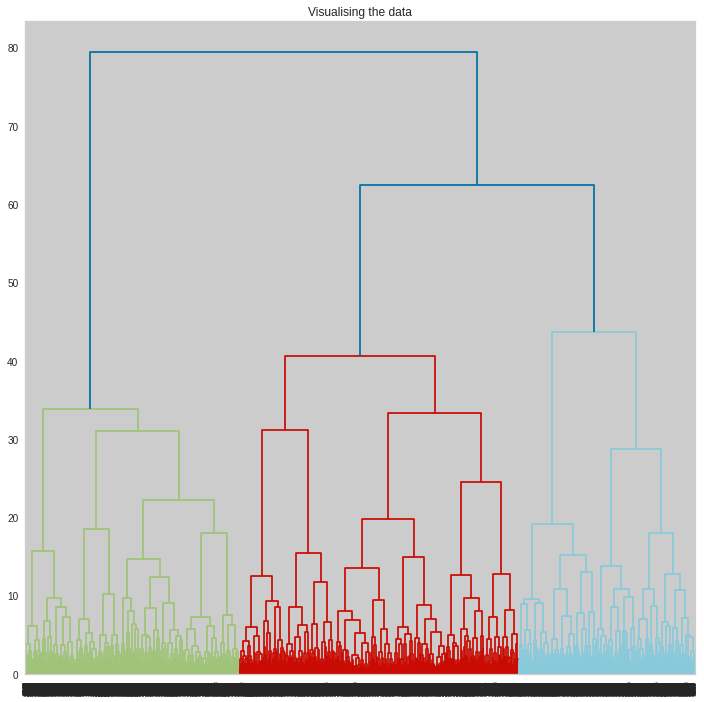

In [93]:
# Dendograms are used to divide a given cluster into many different clusters.

#  Visualizing the working of the Dendograms

plt.figure(figsize =(12, 12))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_train, method ='ward')))

In [94]:
y_train, y_test  = train_test_split(
                     X_principal,  test_size=0.2, random_state=0)

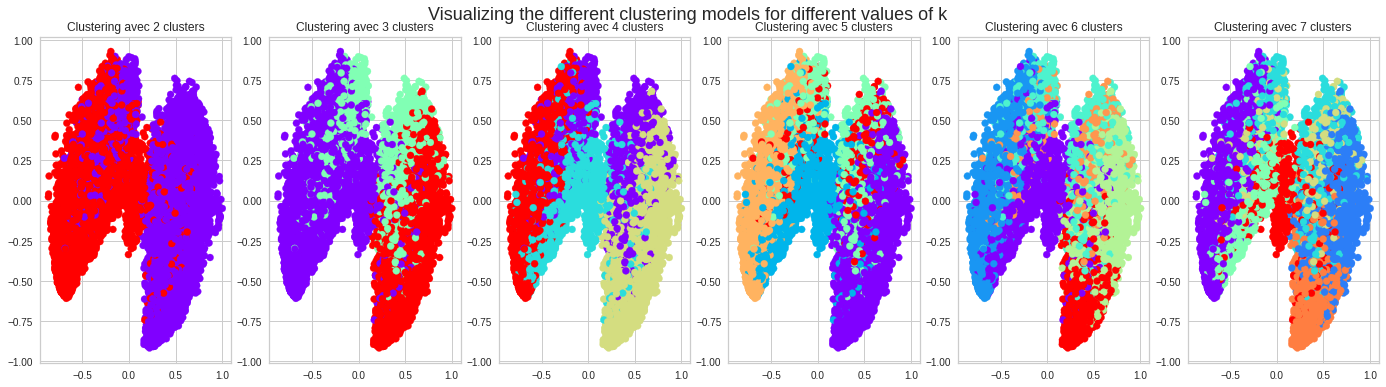

In [95]:
#  Building and Visualizing the different clustering models for different values of k

count=0
silhouette_scores = []
fig, ax = plt.subplots(1, 6, figsize = (24, 6))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Visualizing the different clustering models for different values of k", fontsize=18, y=0.95)
for i in range(2,8):
    
    ac2 = AgglomerativeClustering(n_clusters = i)

    # Visualizing the clustering

    ax[count].scatter(y_test['P1'], y_test['P2'],
                c = ac2.fit_predict(y_test), cmap ='rainbow')
    ax[count].set_title(f"Clustering avec {i} clusters")
    
# Evaluating the different models and Visualizing the results.

    # Appending the silhouette scores of the different models to the list
    
    silhouette_scores.append(
            silhouette_score(y_test, ac2.fit_predict(y_test)))
    count+=1

### Ici, nous allons utiliser les scores de Silhouette pour choisir le nb de cluster optimal.

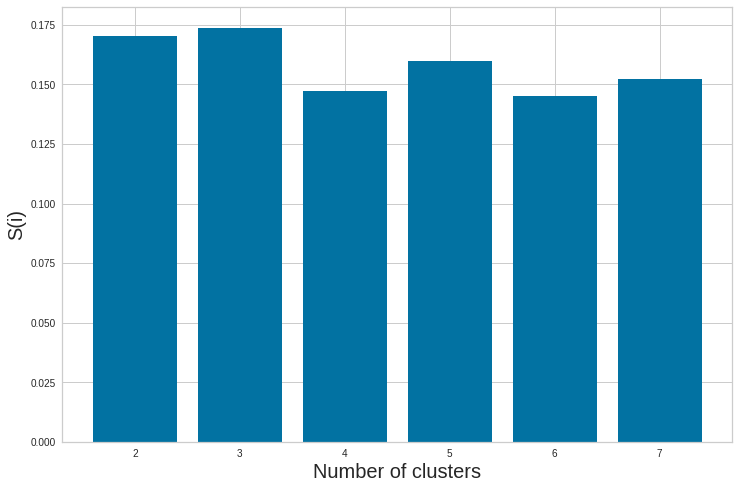

In [96]:
# Plotting a bar graph to compare the results
k = [2, 3, 4, 5, 6, 7]
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 20)
plt.ylabel('S(i)', fontsize = 20)
plt.show()

###  Le meilleur score Silhouette est de 0.175 (ce qui est bas) et il est attribué aux 3 clusters

In [97]:
ward = AgglomerativeClustering(
    n_clusters=3, linkage="ward"
).fit(y_test)
labels_ward = ward.labels_



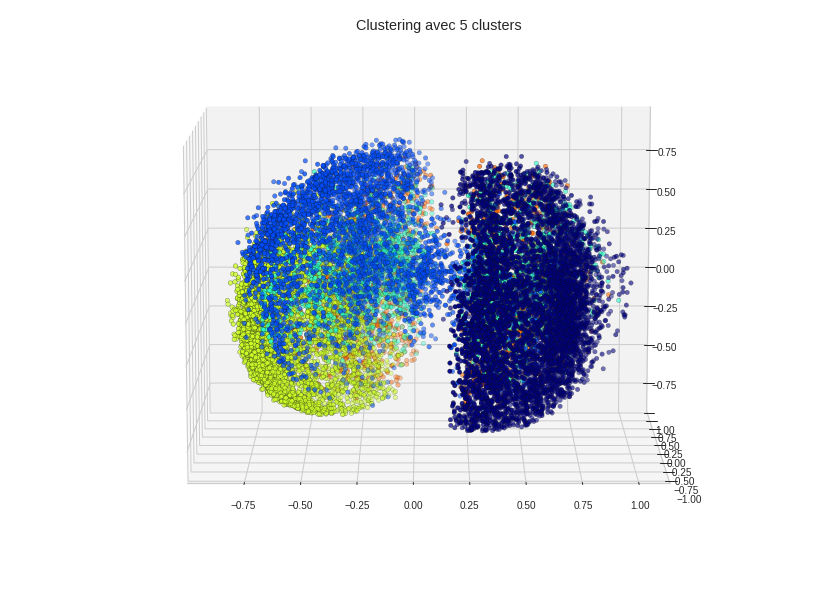

In [98]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection="3d", elev=10, azim=-90)
ax1.set_position([0, 0, 0.95, 1])
for l in np.unique(labels_ward):
    ax1.scatter(
        np.array(y_test)[labels_ward == l,0],
        np.array(y_test)[labels_ward == l,1],
        np.array(y_test)[labels_ward == l,2],
        color=plt.cm.jet(float(l) / np.max(labels_ward + 1)),
        s=20,
        edgecolor="k",
    )
_ = fig1.suptitle(f"Clustering avec {len(np.unique(labels_ward))} clusters")

In [99]:
#découpage à la hauteur t = 40==> identifiants de 5 groupes obtenus
from scipy.cluster.hierarchy import ward, fcluster
from scipy.cluster.hierarchy import linkage,dendrogram
Z = linkage(X_train,method='ward',metric='euclidean')
groupes_cah_acp = fcluster(Z,t=40,criterion='distance')
print(groupes_cah_acp)
#index trié des groupes
idg = np.argsort(groupes_cah_acp)
#affichage des observations et leurs groupes
print(pd.DataFrame(y_test.index[idg],groupes_cah_acp[idg]))

[3 3 2 ... 5 1 1]
        0
1   29614
1     910
1   83864
1   83547
1   27172
..    ...
5    8221
5   87351
5   66995
5    5603
5   80880

[18671 rows x 1 columns]


In [100]:
clust_cah_acp = pd.DataFrame({ "cluster": groupes_cah_acp[idg], "clients": y_test.index[idg] })
print(clust_cah_acp)
clust_pivot_cah_acp = clust_cah_acp.pivot_table(index="clients", columns="cluster", aggfunc=len, fill_value=0)

       cluster  clients
0            1    29614
1            1      910
2            1    83864
3            1    83547
4            1    27172
...        ...      ...
18666        5     8221
18667        5    87351
18668        5    66995
18669        5     5603
18670        5    80880

[18671 rows x 2 columns]


In [101]:
test_acp = data_bis.reset_index().copy()

In [102]:
test_acp = test_acp[test_acp.index.isin(clust_pivot_cah_acp.index)]

In [103]:
test_acp["cluster_CAH"] = clust_cah_acp.sort_values("clients")["cluster"].values

In [104]:
test_acp["cluster_Kmeans_PCA"] = X_scaled_bis[X_scaled_bis["kmeans_label_pca"].index.isin(test_acp["customer_unique_id"])]["kmeans_label_pca"].values +1 

In [105]:
test_acp["kmeans_label"] = X_scaled_bis[X_scaled_bis["kmeans_label"].index.isin(test_acp["customer_unique_id"])]["kmeans_label"].values +1 

In [106]:
y_test_acp= test_acp.copy()
y_test_acp = round(y_test_acp.groupby(by="cluster_CAH").mean(),2)

In [107]:
scaler = MinMaxScaler()
X_scaled_test = scaler.fit_transform(y_test_acp)
X_scaled_test = pd.DataFrame(X_scaled_test, index=y_test_acp.index, columns=y_test_acp.columns)

# Group by cluster

y_test_acp.drop(["cluster_Kmeans_PCA","kmeans_label"],axis=1,inplace=True)
# Plot Radar chart
plot_radars(data=y_test_acp,
            group="cluster_CAH")

### L'interprétation métier des clusters n'est pas représentative car le modèle CAH mène à un problème de fuite mémoire et ne voulant pas réduire le nombre de clients en faisant appel à un échantillonage, j'ai décidé de ne pas aller plus loin a propos de ce type de modèle...


In [286]:
interpretation_cluster(test_acp, group='cluster_CAH',clust=1)

,% Chiffre Affaire,Montant des Dépenses,Nombre de commandes,Nombre d'articles,Nouveaux clients,Durée livraison,Satisfaction,Top 3 Catégories,Flop 3 Catégories,Paiement en x fois,Nb Moyens de Paiement
1,*****,*****,***,**,***,**,*****,"[1#: home_furniture, 2#: technology, 3#: other]","[1#: groceries_food_drink, 2#: books_cds_media...",****,**
2,**,***,**,****,,,*****,"[1#: home_furniture, 2#: technology, 3#: other]","[1#: books_cds_media, 2#: groceries_food_drink...",*****,***
3,****,****,****,*****,**,****,*****,"[1#: home_furniture, 2#: technology, 3#: other]","[1#: groceries_food_drink, 2#: books_cds_media...",***,
4,,,,,*****,***,*****,"[1#: home_furniture, 2#: technology, 3#: other]","[1#: books_cds_media, 2#: groceries_food_drink...",**,*****
5,***,**,*****,***,****,*****,*****,"[1#: home_furniture, 2#: technology, 3#: other]","[1#: groceries_food_drink, 2#: books_cds_media...",,****


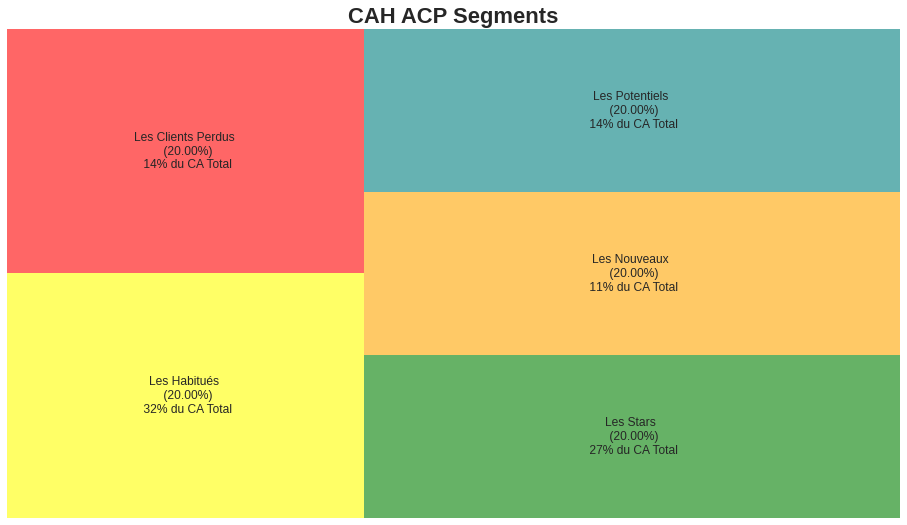

In [288]:
# Sample 18 000
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16,9)
perc = [f'{i/y_test_acp.groupby("cluster_CAH").count()["nb_orders"].sum()*100:5.2f}%' for i in y_test_acp.groupby("cluster_CAH").count()["nb_orders"]]
CA = (test_acp.groupby("cluster_CAH").sum()["total_spend"]  / test_acp.groupby("cluster_CAH").sum()["total_spend"].round(0).sum() * 100).round(2)

CA_clean=[]
for i in CA.tolist():
  CA_clean.append('{:,}% du CA Total'.format(int(i)).replace(',', ' '))
lbl = [f'{el[0]} \n ({el[1]})\n {el[2]}' for el in zip( y_test_acp.groupby("cluster_CAH")["nb_orders"].count().rename({
                                               1: "Les Habitués",
                                               2 :"Les Clients Perdus",
                                               3 :"Les Stars",
                                               4: "Les Nouveaux",
                                               5: "Les Potentiels"},axis=0).index, perc,CA_clean)]
squarify.plot(sizes= y_test_acp.groupby("cluster_CAH")["nb_orders"].count(),
              label = lbl,
              
              color = ["Yellow","Red","Green","Orange","Teal"],
              alpha=.6)
plt.title("CAH ACP Segments", fontsize = 22, fontweight="bold")
plt.axis("off")
plt.show()

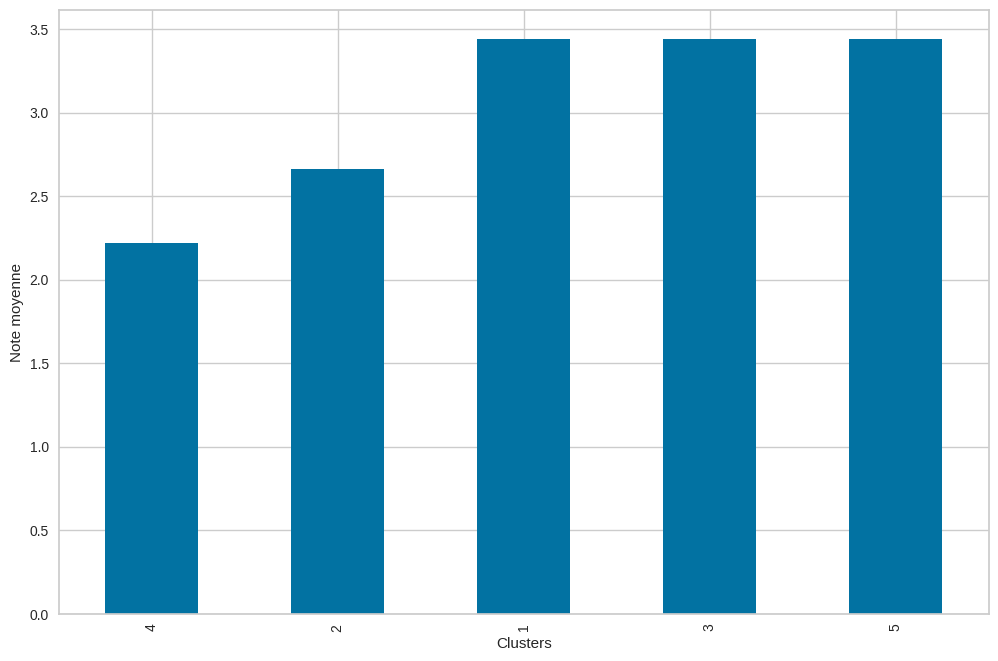

In [274]:
plt_note_cluster(interpretation=interpretation_cluster(test_acp, group='cluster_CAH',clust=1))

# CLUSTERING PAR DBSCAN

In [126]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [143]:
# Nous allons déterminer grâce à la méthode du coude : epsilon optimal
from sklearn.neighbors import NearestNeighbors


neigh = NearestNeighbors(n_neighbors=2*X_principal.shape[1])
nbrs = neigh.fit(X_principal)
distances, indices = nbrs.kneighbors(X_principal)
distances = np.sort(distances, axis=0)
distances = distances[:,1]


0.1684945712432899


<Figure size 360x360 with 0 Axes>

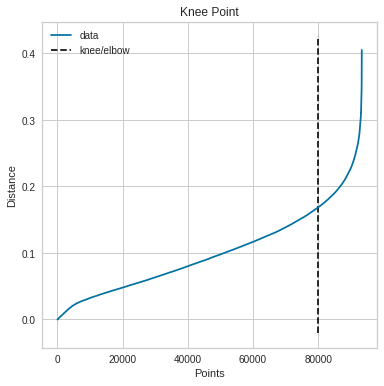

In [144]:
from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

In [129]:
# Ici , nous allons déterminer le min_samples en faisant une itération et se rapprocher du K optimal du Kmeans soit 5
for i in range(100,110):
    db_default = DBSCAN(eps = 0.168, min_samples = i).fit(X_principal)
    core_samples_mask = np.zeros_like(db_default.labels_, dtype=bool)
    core_samples_mask[db_default.core_sample_indices_] = True
    labels = db_default.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"Pour min_samples= {i}, Nb total de clusters : {n_clusters_}")
    if n_clusters_ ==5:
        break

Pour min_samples= 100, Nb total de clusters : 6
Pour min_samples= 101, Nb total de clusters : 6
Pour min_samples= 102, Nb total de clusters : 6
Pour min_samples= 103, Nb total de clusters : 6
Pour min_samples= 104, Nb total de clusters : 6
Pour min_samples= 105, Nb total de clusters : 6
Pour min_samples= 106, Nb total de clusters : 6
Pour min_samples= 107, Nb total de clusters : 7
Pour min_samples= 108, Nb total de clusters : 7
Pour min_samples= 109, Nb total de clusters : 7


In [130]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [145]:
# Building the clustering model
from sklearn import metrics
labels_true = X_scaled_bis["kmeans_label_pca"].values
# Numpy array of all the cluster labels assigned to each data point
db_default = DBSCAN(eps = distances[knee.knee], min_samples = 2*X_principal.shape[1]).fit(X_principal)
core_samples_mask = np.zeros_like(db_default.labels_, dtype=bool)
core_samples_mask[db_default.core_sample_indices_] = True
labels = db_default.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.4f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.4f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.4f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.4f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.4f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.4f"
      % metrics.silhouette_score(X_principal, labels))

Estimated number of clusters: 63
Estimated number of noise points: 48754
Homogeneity: 0.2874
Completeness: 0.2817
V-measure: 0.2845
Adjusted Rand Index: 0.0869
Adjusted Mutual Information: 0.2839
Silhouette Coefficient: -0.4550


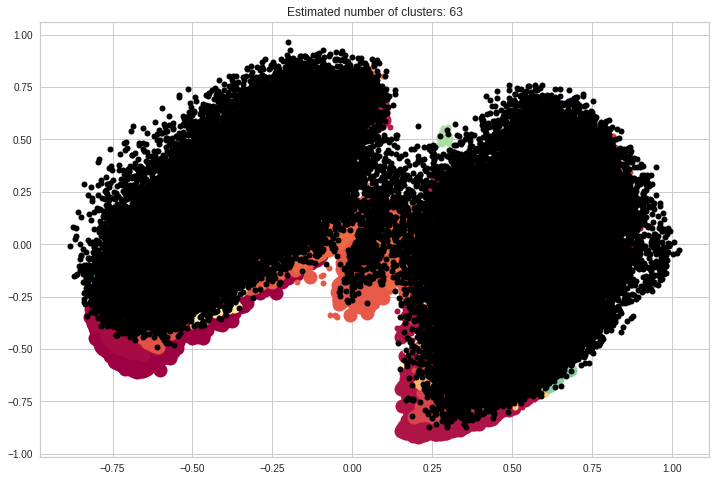

In [146]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_principal[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X_principal[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## DBSCAN clustering de la donnée brute (sans PCA)

0.19026545671605488


<Figure size 360x360 with 0 Axes>

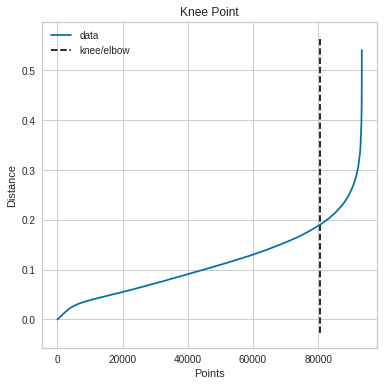

In [133]:
neigh = NearestNeighbors(n_neighbors=2*X_normalized.shape[1])
nbrs = neigh.fit(X_normalized)
distances, indices = nbrs.kneighbors(X_normalized)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

In [ ]:
"""i=121
n_clusters_ = 6
while n_clusters_ >4:
    db_default = DBSCAN(eps = 0.194, min_samples = i).fit(X_normalized)
    core_samples_mask = np.zeros_like(db_default.labels_, dtype=bool)
    core_samples_mask[db_default.core_sample_indices_] = True
    labels = db_default.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"Pour min_samples= {i}, Nb total de clusters : {n_clusters_}")
    i+=1
    """

In [ ]:
np.unique(labels)

In [137]:
# Building the clustering model
from sklearn import metrics
labels_true = X_scaled_bis["kmeans_label_pca"].values
# Numpy array of all the cluster labels assigned to each data point
db_default = DBSCAN(eps = distances[knee.knee], min_samples = 2*X_normalized.shape[1]).fit(X_normalized)
core_samples_mask = np.zeros_like(db_default.labels_, dtype=bool)
core_samples_mask[db_default.core_sample_indices_] = True
labels = db_default.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print(f'% of noise: {np.round((n_noise/len(X)) * 100, decimals=1)}%')
print("Homogeneity: %0.4f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.4f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.4f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.4f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.4f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.4f"
      % metrics.silhouette_score(X_normalized, labels))

Estimated number of clusters: 29
Estimated number of noise points: 51438
Homogeneity: 0.2708
Completeness: 0.3179
V-measure: 0.2925
Adjusted Rand Index: 0.1015
Adjusted Mutual Information: 0.2922
Silhouette Coefficient: -0.3306


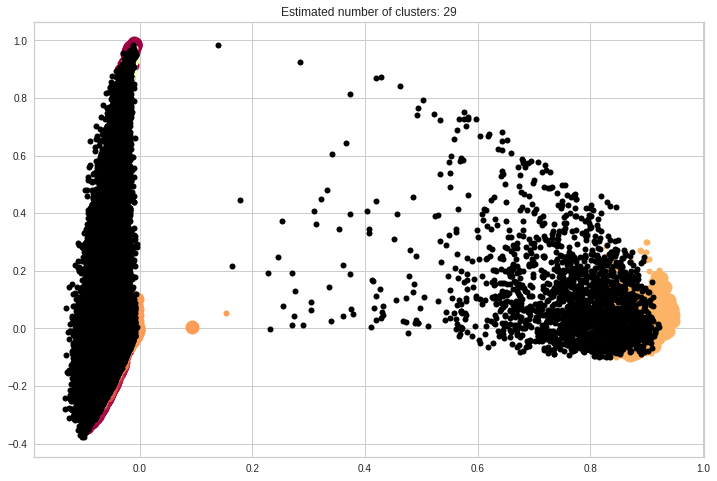

In [138]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_normalized[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X_normalized[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# **Conclusion**

#### En conclusion on a partitionné notre dataset clients en utilisant differents algorithmes dont K-Means, la classification hiérarchique ascendante selon Ward, et DBSCAN, les resultas malgré certaines imperfections tournent autour de 5 clusters ,mais le plus probants quant au score (silhouette), fit-time,ainsi que son score à l'initialisation  est le modele K-Means avec ACP dont on garde les resultats.

## Interprétation métier des clusters

0. * **`Les Stars`** : Nouveaux Clients proches géographiquement avec de courts délais de livraison mais avec un frais de port élevé, commande sur le site peu d'articles. Ils ont acheté en milieu d'année pour des montants faibles. Ils paient en une fois avec plusieurs types de moyen de paiement. Les avis de ces clients sont très bons. Ils sont intéressés surtout pour **l'aménagement de la maison et les produits de beauté**. *Ce groupe de client obtient la note moyenne la plus élevée dans mon classement. Il nécessite sans doute une attention toute particulière.*

1. * **`Les Clients Perdus`** : Clients assez éloignés géographiquement avec de courts délais de livraison mais un frais de port assez élevé, leur nombre de commande passé sur le site est faible et se situe principalement en début d'année pour des montants faible. Ils paient avec plusieurs type de moyen de paiement et en plusieurs fois. Les avis de ces clients sont bons. Mais Ils ont tendance à espacer les délais entre 2 commandes. Leur dernière commande date d'il y a 2 ans. Ils sont intéressés surtout pour **l'aménagement de la maison et les produits high tech**. *Ce groupe de client obtient la note moyenne la plus basse dans mon classement. Il nécessite sans doute une attention toute particulière.*
2. * **`Les Insatisfaits`** : Ce sont des clients mécontents (les avis sont mauvais). Regroupe les clients qui utilisent plusieurs moyens de paiement et un nombre moyen d'échéances. Les délais de livraison sont très importants et les frais de port élevés en raison de l'éloignement géographique. Ce sont cependant les clients qui ont le plus dépensé et ont acheté un grand nombre d'articles. En revanche, le nombre de commandes passées sur le site est moyen. Ils sont intéressés surtout pour **l'aménagement de la maison et les produits high tech**.
3. * **`Les Nouveaux`** : Nouveaux Clients (< 6 mois) de début d'année. Ils règlent comptant pour des montants faibles. Ces clients sont géographiquement peu éloignés et les délais de livraison sont courts. Les avis de ces clients sont également très bons. Ils comptent parmi ceux qui commandent le plus alors qu'ils sont nouveaux. Ils sont intéressés surtout pour **l'aménagement de la maison et les produits high tech**. *Futurs gros acheteurs*
4. * **`Les Habitués`** : Clients proches géographiquement avec de courts délais de livraison et un frais de port bas, ayant commandé plusieurs fois principalement en fin d'année pour des montants faibles. Ils paient avec plusieurs types de moyen de paiement et avec au maximum 2 échéances. Les avis de ces clients sont très bons. Ils sont intéressés surtout pour **l'aménagement de la maison, les produits high tech et les produits de beauté**.



### Quant à la maintenance Il faudra donc prévoir celle du programme de segmentation tous les 4 mois dans un premier temps puis re-tester cette stabilité temporelle au fil du temps afin de l'affiner,  en veillant à  redéfinir les segments clients à chaque maintenance.

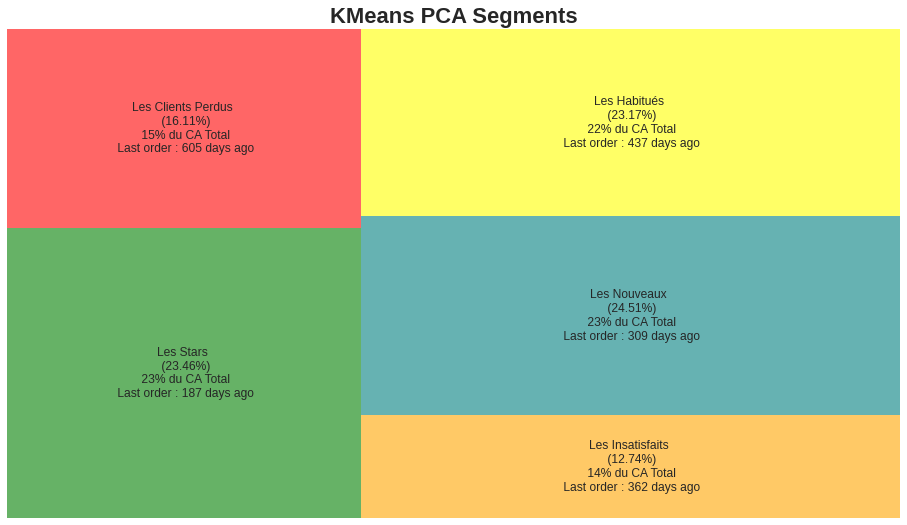

In [289]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16,9)
perc = [f'{i/X_scaled_bis.groupby("kmeans_label_pca").count()["nb_orders"].sum()*100:5.2f}%' for i in X_scaled_bis.groupby("kmeans_label_pca").count()["nb_orders"]]
X_bis["kmeans_label_pca"] = pca_kmeans_labels
Recency = X_bis.groupby("kmeans_label_pca").mean()["recency"].round(0)
CA = (X_bis.groupby("kmeans_label_pca").sum()["total_spend"]  / X_bis.groupby("kmeans_label_pca").sum()["total_spend"].round(0).sum() * 100).round(2)

CA_clean=[]
for i in CA.tolist():
  CA_clean.append('{:,}% du CA Total'.format(int(i)).replace(',', ' '))
lbl = [f'{el[0]} \n ({el[1]})\n {el[2]}\n Last order : {int(el[3])} days ago' for el in zip( X_scaled_bis.groupby("kmeans_label_pca")["nb_orders"].count().rename({
                                               0: "Les Stars",
                                               1 :"Les Clients Perdus",
                                               2 :"Les Insatisfaits",
                                               3: "Les Nouveaux",
                                               4: "Les Habitués"},axis=0).index, perc,CA_clean,Recency)]
squarify.plot(sizes= X_scaled_bis.groupby("kmeans_label_pca")["nb_orders"].count(),
              label = lbl,
              
              color = ["Green","Red","Orange","Teal","Yellow"],
              alpha=.6)
plt.title("KMeans PCA Segments", fontsize = 22, fontweight="bold")
plt.axis("off")
plt.show()

In [277]:
interpretation_cluster(X_bis, group='kmeans_label_pca')

,% Chiffre Affaire,Montant des Dépenses,Nombre de commandes,Nombre d'articles,Nouveaux clients,Durée livraison,Satisfaction,Top 3 Catégories,Flop 3 Catégories,Paiement en x fois,Nb Moyens de Paiement
0,****,****,**,**,*****,*****,*****,"[1#: home_furniture, 2#: other, 3#: health_bea...","[1#: books_cds_media, 2#: groceries_food_drink...",*****,****
1,**,**,,,,****,*****,"[1#: home_furniture, 2#: technology, 3#: healt...","[1#: groceries_food_drink, 2#: books_cds_media...",,**
2,,*****,***,*****,***,,,"[1#: home_furniture, 2#: technology, 3#: other]","[1#: books_cds_media, 2#: groceries_food_drink...",**,
3,*****,,*****,***,****,**,*****,"[1#: home_furniture, 2#: technology, 3#: other]","[1#: books_cds_media, 2#: groceries_food_drink...",****,*****
4,***,***,****,****,**,***,*****,"[1#: home_furniture, 2#: technology, 3#: healt...","[1#: books_cds_media, 2#: groceries_food_drink...",***,***


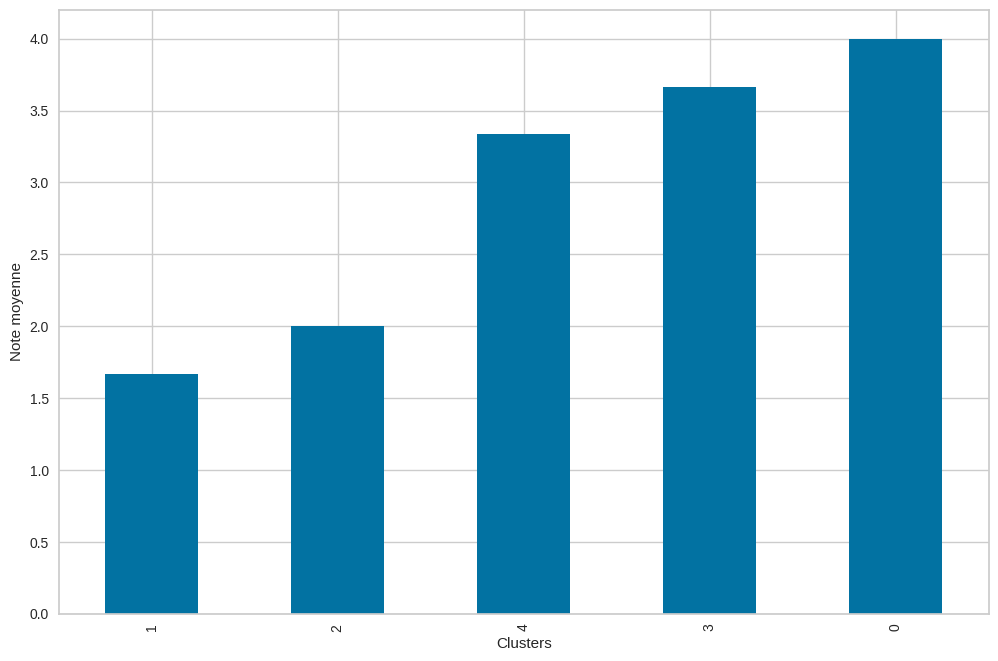

In [278]:
plt_note_cluster()